# Part 1. Camera calibration

Using the photos taken with the camera and the 9x6 chessboard we extract the calibration coefficients k1,k2,k3 and save in a Python serializable object

In [1]:
#Most of this code was commited to https://github.com/udacity/CarND-Camera-Calibration by Ryan Keenan.

import  numpy  as  np
import  cv2
import  glob
import  matplotlib.pyplot  as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
valids = 0
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        valids += 1
print ("Camera calibration finished. Found "+str(valids)+ " chessboard images out of "+str(len(images))+" provided files.")


Camera calibration finished. Found 17 chessboard images out of 20 provided files.


Text(0.5,1,'Undistorted Image')

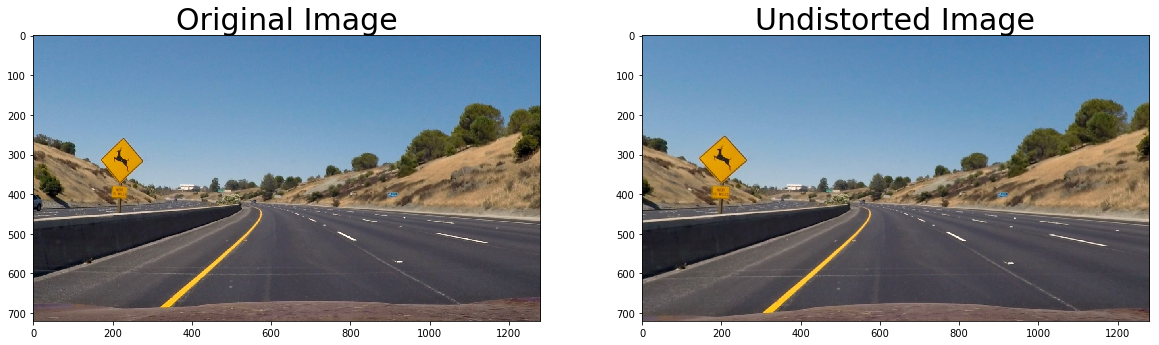

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
originalimg = cv2.imread('./test_images/test2.jpg')
img_size = (originalimg.shape[1], originalimg.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


undistorted = cv2.undistort(originalimg, mtx, dist, None, mtx)
cv2.imwrite('./output/test_undist1.jpg',undistorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
undistorted = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
originalimg = cv2.cvtColor(originalimg, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(originalimg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
def undistort_camera (img, calibration_data_file):
    dist_pickle = pickle.load( open( calibration_data_file, "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    img_size = (img.shape[1], img.shape[0])
    return cv2.undistort(img, mtx, dist, None, mtx)


# Part 2, birds-eye perspective 

I have read that you can do fixing two points at top of image (farthest distance from camera) or two points at bottom (nearest points respect of camera). 

If you warp fixing the bottom points, seems that you add spacial resolution without increasing the information, so the gradient change detection algorithms performance is worse.

See https://nikolasent.github.io/opencv/2017/05/07/Bird's-Eye-View-Transformation.html

The trick here is to play with straight lanes picture. Birds-eye transformed should be straight too, if not we have distorted the lanes.

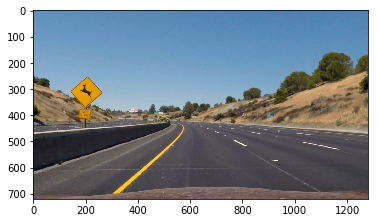

In [4]:
plt.imshow(undistorted) # Show results
plt.show()

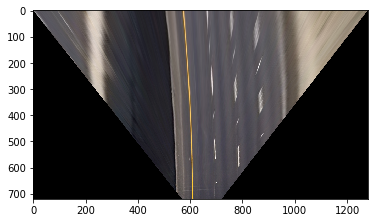

In [5]:
sourcepoints = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
destinationpoints = np.float32([[569, 720], [711, 720], [0, 0], [1280, 0]])
img_size = (10000,10000)

M = cv2.getPerspectiveTransform(sourcepoints, destinationpoints)
Minv = cv2.getPerspectiveTransform(destinationpoints, sourcepoints)

def warp_birds_eye (image,sourcepoints,destinationpoints, inv = False):
    #img_size = (image.shape[1], image.shape[0])
    img_size = (1280,720)
    M = cv2.getPerspectiveTransform(sourcepoints, destinationpoints)
    Minv = cv2.getPerspectiveTransform(destinationpoints, sourcepoints)
    if (inv==False):
        return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    else:
        img_size = (1280, 720)
        return cv2.warpPerspective(image, Minv, img_size, flags=cv2.INTER_LINEAR)
            
warped = warp_birds_eye(undistorted,sourcepoints,destinationpoints,False)
plt.imshow(warped) # Show results
plt.show()

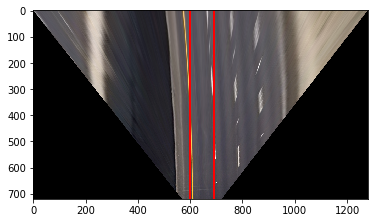

In [6]:
vertical_lines = np.copy(warped)
cv2.line(vertical_lines,(600,0),(600,720),(255,0,0),5)
cv2.line(vertical_lines,(690,0),(690,720),(255,0,0),5)
plt.imshow(vertical_lines) # Show results
plt.show()

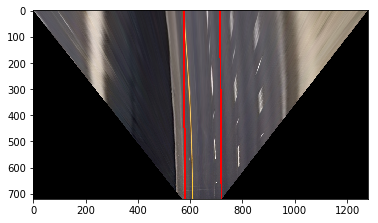

In [7]:
vertical_lines2 = np.copy(warped)
cv2.line(vertical_lines2,(576,0),(580,720),(255,0,0),5)
cv2.line(vertical_lines2,(714,0),(720,720),(255,0,0),5)
plt.imshow(vertical_lines2) # Show results
plt.show()

So, 90px are the wide of the lane (3.7 meters wide) and the suggested relationship of "30/720 # meters per pixel in y dimension" fits perfectly.  

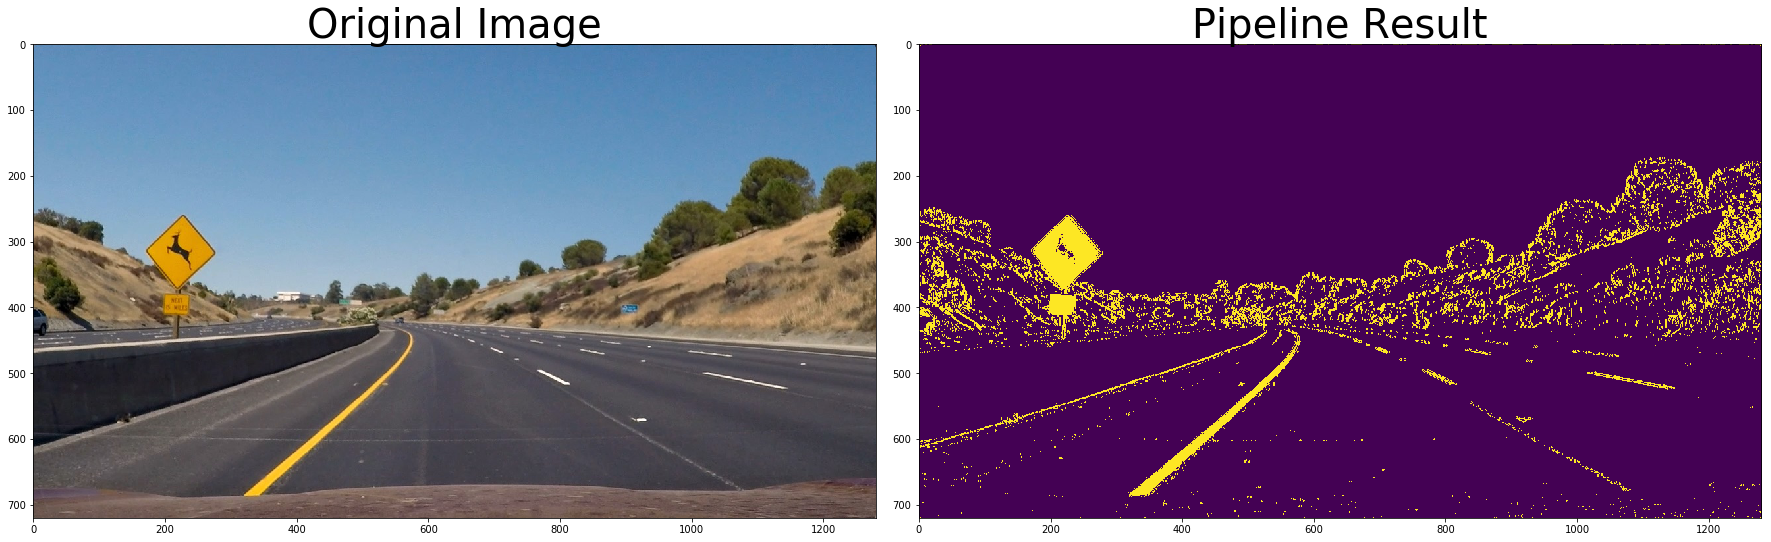

In [8]:

def sobel_schannel_thresholds(img, s_thresh=(180, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


import matplotlib.image as mpimg

curved =  mpimg.imread('./test_images/test2.jpg')  
#curved = cv2.cvtColor(curved, cv2.COLOR_BGR2RGB)
binary = sobel_schannel_thresholds(curved)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(curved)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

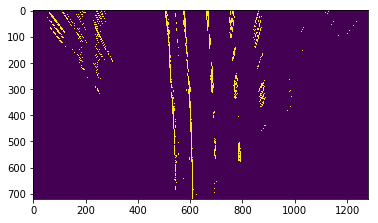

In [9]:
binary_warped = warp_birds_eye(binary,sourcepoints,destinationpoints)

plt.imshow(binary_warped) # Show results
plt.show()

# Part 3, detecting lane lines

## Thresholding in different colour spaces

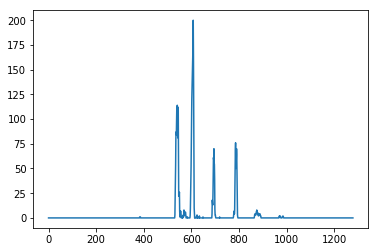

In [10]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)


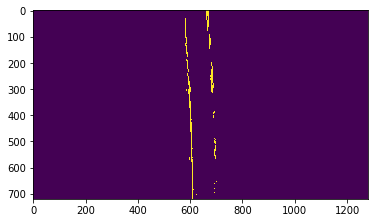

In [11]:
#From previous work 

vertices = np.array([[(580,720),(580,0),(720,0),(720,720)]], dtype=np.int32)
vertices2 = np.array([[(580,720),(580,400),(720,400),(720,720)]], dtype=np.int32)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

binary_warped_cut = region_of_interest(binary_warped,vertices)
plt.imshow(binary_warped_cut)
#vertices = np.array([[(0,imshape[0]),(470, 300), (505, 300), (imshape[1],imshape[0])]], dtype=np.int32)


In [12]:
def find_lanes_sliding_window(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 100
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 20
    # Set minimum number of pixels found to recenter window
    minpix = 12
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

    return (leftx, rightx, lefty,righty,ploty,left_fit,right_fit,out_img)



In [13]:

def find_lanes_from_poly(img,left_fit,right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return (left_fitx,right_fitx)

In [80]:
#Uno se viene calibrado de casa



def pipeline_adv_lane_lines_finding (img, calibration_data_file):
    
    
    
    #1. Distortion correction
    img = undistort_camera (img, calibration_data_file)
    original = img
    
    #2. Color/gradient threshold
    img = sobel_schannel_thresholds(img)
    
    #3. Perspective transform
    src = np.float32([[0, 673], [1207, 673], [0, 450], [1280, 450]])
    dst = np.float32([[569, 720], [711, 720], [0, 0], [1280, 0]])
    #src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    #dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    img = warp_birds_eye(img,src,dst,False)
    
    #4. Region of interest
    
    vertices = np.array([[(580,720),(580,0),(720,0),(720,720)]], dtype=np.int32)
    #vertices = np.array([[(580,720),(580,300),(720,300),(720,720)]], dtype=np.int32)
    img =region_of_interest(img, vertices) 
    
    #5. Find lanes lines
    
    leftx, rightx ,lefty,righty,ploty,left_fit,right_fit,out_img = find_lanes_sliding_window(img)
    
    #6. Compute radius
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radio of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    radius = (left_curverad + right_curverad)/2
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    #7. Draw on original 
    
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(original).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp to real world
    newwarp = warp_birds_eye(color_warp,src,dst,True) 
    final = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    #plt.imshow(final)
    
    #Offset computing, our lanes detect start at y=673 pixels to avoid car hood, so we evaluate polynomies at 673
    
    leftlane_nearcar = left_fit_cr[0]*720**2 + left_fit_cr[1]*720 + left_fit_cr[2]
    rightlane_nearcar = right_fit_cr[0]*720**2 + right_fit_cr[1]*720 + right_fit_cr[2]
    
    offset = (((1280/2)*xm_per_pix)  - ((leftlane_nearcar + rightlane_nearcar)/2))* xm_per_pix
    print (offset)
    return final,radius,offset

#pipeline_adv_lane_lines_finding (cv2.cvtColor(cv2.imread('./test_images/test2.jpg'), cv2.COLOR_BGR2RGB), "wide_dist_pickle.p")

-0.07725479932688187
-0.07725479932688187


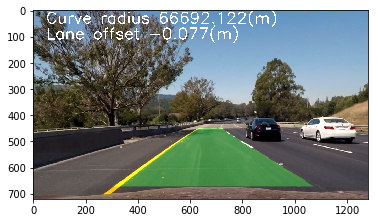

In [84]:
def video_pipeline(img):
    result,radio,lane_offset = pipeline_adv_lane_lines_finding(img,"wide_dist_pickle.p")
    #print on video frames the info
    cv2.putText(result, 'Curve radius {:.3f}(m)'.format(radio), (50,50),cv2.FONT_HERSHEY_SIMPLEX , fontScale = 2, color=(255,255,255), thickness = 3)
    cv2.putText(result, 'Lane offset {:.3f}(m)'.format(lane_offset), (50,110),cv2.FONT_HERSHEY_SIMPLEX , fontScale = 2, color=(255,255,255), thickness = 3)

    print(lane_offset)
    return result
plt.imshow(video_pipeline(cv2.cvtColor(cv2.imread('./test_images/test6.jpg'), cv2.COLOR_BGR2RGB)))

In [20]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    return video_pipeline(image)

lanes_detect = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(lanes_detect, audio=False)

0.28130879857892227
0.28130879857892227
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

0.28130879857892227
0.28130879857892227
0.317569139155536
0.317569139155536


  0%|▏                                                                                | 2/1261 [00:00<02:06,  9.95it/s]

0.34093428685157323
0.34093428685157323


  0%|▏                                                                                | 3/1261 [00:00<02:08,  9.77it/s]

0.2817378992134088
0.2817378992134088


  0%|▎                                                                                | 4/1261 [00:00<02:11,  9.57it/s]

0.32763156094197965
0.32763156094197965


  0%|▎                                                                                | 5/1261 [00:00<02:11,  9.58it/s]

0.41074667138534016
0.41074667138534016


  0%|▍                                                                                | 6/1261 [00:00<02:14,  9.35it/s]

0.3967115354543184
0.3967115354543184


  1%|▍                                                                                | 7/1261 [00:00<02:16,  9.21it/s]

0.37862824544680007
0.37862824544680007
0.2658524977166027
0.2658524977166027


  1%|▌                                                                                | 9/1261 [00:00<02:14,  9.32it/s]

0.30303910300500625
0.30303910300500625


  1%|▋                                                                               | 10/1261 [00:01<02:14,  9.27it/s]

0.24870313473520803
0.24870313473520803


  1%|▋                                                                               | 11/1261 [00:01<02:14,  9.29it/s]

0.23866848814719585
0.23866848814719585


  1%|▊                                                                               | 12/1261 [00:01<02:14,  9.27it/s]

0.199794361300481
0.199794361300481


  1%|▊                                                                               | 13/1261 [00:01<02:14,  9.29it/s]

0.23040016788477097
0.23040016788477097


  1%|▉                                                                               | 14/1261 [00:01<02:13,  9.32it/s]

0.26870743837575367
0.26870743837575367


  1%|▉                                                                               | 15/1261 [00:01<02:13,  9.33it/s]

0.28194986220893004
0.28194986220893004


  1%|█                                                                               | 16/1261 [00:01<02:14,  9.28it/s]

0.37271760634073214
0.37271760634073214


  1%|█                                                                               | 17/1261 [00:01<02:14,  9.25it/s]

0.3812949772390431
0.3812949772390431


  1%|█▏                                                                              | 18/1261 [00:01<02:13,  9.28it/s]

0.37911568764782433
0.37911568764782433


  2%|█▏                                                                              | 19/1261 [00:02<02:13,  9.30it/s]

0.3844120206008576
0.3844120206008576


  2%|█▎                                                                              | 20/1261 [00:02<02:13,  9.32it/s]

0.3619001940322704
0.3619001940322704


  2%|█▎                                                                              | 21/1261 [00:02<02:12,  9.34it/s]

0.34314752227248463
0.34314752227248463


  2%|█▍                                                                              | 22/1261 [00:02<02:12,  9.35it/s]

0.4471708986459305
0.4471708986459305


  2%|█▍                                                                              | 23/1261 [00:02<02:12,  9.33it/s]

0.39349159807847994
0.39349159807847994


  2%|█▌                                                                              | 24/1261 [00:02<02:12,  9.36it/s]

0.3066360624899199
0.3066360624899199


  2%|█▌                                                                              | 25/1261 [00:02<02:11,  9.37it/s]

0.2531268367324707
0.2531268367324707


  2%|█▋                                                                              | 26/1261 [00:02<02:11,  9.36it/s]

0.23946482961790472
0.23946482961790472


  2%|█▋                                                                              | 27/1261 [00:02<02:12,  9.33it/s]

0.24289007155322634
0.24289007155322634


  2%|█▊                                                                              | 28/1261 [00:03<02:12,  9.33it/s]

0.2823535475646551
0.2823535475646551
0.3160803772803419
0.3160803772803419


  2%|█▉                                                                              | 30/1261 [00:03<02:11,  9.35it/s]

0.401465609417269
0.401465609417269


  2%|█▉                                                                              | 31/1261 [00:03<02:11,  9.36it/s]

0.4923265000809431
0.4923265000809431


  3%|██                                                                              | 32/1261 [00:03<02:11,  9.36it/s]

0.5596123300750774
0.5596123300750774
0.4952246481413314
0.4952246481413314


  3%|██▏                                                                             | 34/1261 [00:03<02:10,  9.38it/s]

0.4659097225089594
0.4659097225089594


  3%|██▏                                                                             | 35/1261 [00:03<02:11,  9.35it/s]

0.40925050179706335
0.40925050179706335


  3%|██▎                                                                             | 36/1261 [00:03<02:11,  9.34it/s]

0.41280917636794556
0.41280917636794556


  3%|██▎                                                                             | 37/1261 [00:03<02:11,  9.34it/s]

0.4927226245413365
0.4927226245413365


  3%|██▍                                                                             | 38/1261 [00:04<02:11,  9.32it/s]

0.5010901343138379
0.5010901343138379
0.53366667707273
0.53366667707273


  3%|██▌                                                                             | 40/1261 [00:04<02:10,  9.37it/s]

0.55499921513341
0.55499921513341
0.5305533533309198
0.5305533533309198


  3%|██▋                                                                             | 42/1261 [00:04<02:10,  9.37it/s]

0.520333427350606
0.520333427350606


  3%|██▋                                                                             | 43/1261 [00:04<02:10,  9.31it/s]

0.5056519580446512
0.5056519580446512


  3%|██▊                                                                             | 44/1261 [00:04<02:11,  9.27it/s]

0.5080532534741066
0.5080532534741066


  4%|██▊                                                                             | 45/1261 [00:04<02:11,  9.24it/s]

0.4949679143143707
0.4949679143143707


  4%|██▉                                                                             | 46/1261 [00:05<02:12,  9.20it/s]

0.44392692385650817
0.44392692385650817


  4%|██▉                                                                             | 47/1261 [00:05<02:12,  9.17it/s]

0.37277122165051974
0.37277122165051974


  4%|███                                                                             | 48/1261 [00:05<02:13,  9.11it/s]

0.3637604894952843
0.3637604894952843


  4%|███                                                                             | 49/1261 [00:05<02:13,  9.10it/s]

0.31254216686537856
0.31254216686537856


  4%|███▏                                                                            | 50/1261 [00:05<02:13,  9.09it/s]

0.28470325350244857
0.28470325350244857


  4%|███▏                                                                            | 51/1261 [00:05<02:13,  9.08it/s]

0.3263894407671901
0.3263894407671901


  4%|███▎                                                                            | 52/1261 [00:05<02:13,  9.06it/s]

0.2902493462808106
0.2902493462808106


  4%|███▎                                                                            | 53/1261 [00:05<02:13,  9.05it/s]

0.32428153436434465
0.32428153436434465


  4%|███▍                                                                            | 54/1261 [00:05<02:13,  9.04it/s]

0.3174872992380692
0.3174872992380692


  4%|███▍                                                                            | 55/1261 [00:06<02:13,  9.00it/s]

0.32708736527738685
0.32708736527738685


  4%|███▌                                                                            | 56/1261 [00:06<02:14,  8.98it/s]

0.34769746172784954
0.34769746172784954


  5%|███▌                                                                            | 57/1261 [00:06<02:14,  8.95it/s]

0.34830490534240655
0.34830490534240655


  5%|███▋                                                                            | 58/1261 [00:06<02:14,  8.93it/s]

0.26818098997923007
0.26818098997923007


  5%|███▋                                                                            | 59/1261 [00:06<02:14,  8.93it/s]

0.3011582511419444
0.3011582511419444


  5%|███▊                                                                            | 60/1261 [00:06<02:14,  8.92it/s]

0.35277151256253425
0.35277151256253425


  5%|███▊                                                                            | 61/1261 [00:06<02:14,  8.92it/s]

0.4256984666064165
0.4256984666064165


  5%|███▉                                                                            | 62/1261 [00:06<02:14,  8.94it/s]

0.38920329151376537
0.38920329151376537


  5%|███▉                                                                            | 63/1261 [00:07<02:14,  8.92it/s]

0.4337637210142939
0.4337637210142939


  5%|████                                                                            | 64/1261 [00:07<02:14,  8.90it/s]

0.4397430454794008
0.4397430454794008


  5%|████                                                                            | 65/1261 [00:07<02:14,  8.91it/s]

0.3836212028361119
0.3836212028361119


  5%|████▏                                                                           | 66/1261 [00:07<02:13,  8.92it/s]

0.35607824940231125
0.35607824940231125


  5%|████▎                                                                           | 67/1261 [00:07<02:13,  8.93it/s]

0.3346623180836699
0.3346623180836699


  5%|████▎                                                                           | 68/1261 [00:07<02:13,  8.91it/s]

0.32103688002628206
0.32103688002628206


  5%|████▍                                                                           | 69/1261 [00:07<02:13,  8.90it/s]

0.2933366491892201
0.2933366491892201


  6%|████▍                                                                           | 70/1261 [00:07<02:13,  8.90it/s]

0.2892766920250605
0.2892766920250605


  6%|████▌                                                                           | 71/1261 [00:07<02:13,  8.90it/s]

0.2528983958113531
0.2528983958113531


  6%|████▌                                                                           | 72/1261 [00:08<02:13,  8.89it/s]

0.27550006572425156
0.27550006572425156


  6%|████▋                                                                           | 73/1261 [00:08<02:13,  8.88it/s]

0.2710467660744852
0.2710467660744852


  6%|████▋                                                                           | 74/1261 [00:08<02:13,  8.87it/s]

0.26443464077710926
0.26443464077710926


  6%|████▊                                                                           | 75/1261 [00:08<02:13,  8.88it/s]

0.27470775448736423
0.27470775448736423


  6%|████▊                                                                           | 76/1261 [00:08<02:13,  8.86it/s]

0.25276337786661807
0.25276337786661807


  6%|████▉                                                                           | 77/1261 [00:08<02:13,  8.86it/s]

0.24353064122849027
0.24353064122849027


  6%|████▉                                                                           | 78/1261 [00:08<02:13,  8.85it/s]

0.24006522164106986
0.24006522164106986


  6%|█████                                                                           | 79/1261 [00:08<02:14,  8.82it/s]

0.23070249785231298
0.23070249785231298


  6%|█████                                                                           | 80/1261 [00:09<02:14,  8.80it/s]

0.3062320935369564
0.3062320935369564


  6%|█████▏                                                                          | 81/1261 [00:09<02:14,  8.80it/s]

0.3311389970792364
0.3311389970792364


  7%|█████▏                                                                          | 82/1261 [00:09<02:14,  8.78it/s]

0.36433586940207763
0.36433586940207763


  7%|█████▎                                                                          | 83/1261 [00:09<02:14,  8.78it/s]

0.31976724487744995
0.31976724487744995


  7%|█████▎                                                                          | 84/1261 [00:09<02:14,  8.77it/s]

0.32068300922304427
0.32068300922304427


  7%|█████▍                                                                          | 85/1261 [00:09<02:14,  8.77it/s]

0.29892157143554865
0.29892157143554865


  7%|█████▍                                                                          | 86/1261 [00:09<02:14,  8.75it/s]

0.29232588313084923
0.29232588313084923


  7%|█████▌                                                                          | 87/1261 [00:09<02:14,  8.73it/s]

0.3499305578192347
0.3499305578192347


  7%|█████▌                                                                          | 88/1261 [00:10<02:14,  8.71it/s]

0.3614695457454244
0.3614695457454244


  7%|█████▋                                                                          | 89/1261 [00:10<02:14,  8.71it/s]

0.45700563894448626
0.45700563894448626


  7%|█████▋                                                                          | 90/1261 [00:10<02:14,  8.70it/s]

0.4271306925828234
0.4271306925828234


  7%|█████▊                                                                          | 91/1261 [00:10<02:14,  8.69it/s]

0.4338042781032221
0.4338042781032221


  7%|█████▊                                                                          | 92/1261 [00:10<02:14,  8.68it/s]

0.4412234598220582
0.4412234598220582


  7%|█████▉                                                                          | 93/1261 [00:10<02:14,  8.68it/s]

0.42153620144347
0.42153620144347


  7%|█████▉                                                                          | 94/1261 [00:10<02:14,  8.67it/s]

0.4310911802290153
0.4310911802290153


  8%|██████                                                                          | 95/1261 [00:10<02:14,  8.68it/s]

0.4142241311181145
0.4142241311181145


  8%|██████                                                                          | 96/1261 [00:11<02:14,  8.68it/s]

0.35830183269067906
0.35830183269067906


  8%|██████▏                                                                         | 97/1261 [00:11<02:14,  8.67it/s]

0.3490100655785843
0.3490100655785843


  8%|██████▏                                                                         | 98/1261 [00:11<02:14,  8.65it/s]

0.36677024716881923
0.36677024716881923


  8%|██████▎                                                                         | 99/1261 [00:11<02:14,  8.63it/s]

0.3696092697499493
0.3696092697499493


  8%|██████▎                                                                        | 100/1261 [00:11<02:14,  8.63it/s]

0.40433321194697686
0.40433321194697686


  8%|██████▎                                                                        | 101/1261 [00:11<02:14,  8.64it/s]

0.42185253437126385
0.42185253437126385


  8%|██████▍                                                                        | 102/1261 [00:11<02:14,  8.64it/s]

0.4306912304167838
0.4306912304167838
0.4249732402670576
0.4249732402670576


  8%|██████▌                                                                        | 104/1261 [00:12<02:13,  8.67it/s]

0.4172453427926505
0.4172453427926505


  8%|██████▌                                                                        | 105/1261 [00:12<02:13,  8.67it/s]

0.4306408614136625
0.4306408614136625


  8%|██████▋                                                                        | 106/1261 [00:12<02:13,  8.66it/s]

0.41425588877724656
0.41425588877724656


  8%|██████▋                                                                        | 107/1261 [00:12<02:13,  8.66it/s]

0.5347013429004834
0.5347013429004834


  9%|██████▊                                                                        | 108/1261 [00:12<02:13,  8.65it/s]

0.4988151988317847
0.4988151988317847


  9%|██████▊                                                                        | 109/1261 [00:12<02:13,  8.65it/s]

0.4730991956842852
0.4730991956842852
0.4131100853043036
0.4131100853043036


  9%|██████▉                                                                        | 111/1261 [00:12<02:12,  8.66it/s]

0.3996426304221603
0.3996426304221603


  9%|███████                                                                        | 112/1261 [00:12<02:12,  8.66it/s]

0.43091093757864596
0.43091093757864596


  9%|███████                                                                        | 113/1261 [00:13<02:12,  8.66it/s]

0.419768880327411
0.419768880327411


  9%|███████▏                                                                       | 114/1261 [00:13<02:12,  8.66it/s]

0.4464294584628633
0.4464294584628633


  9%|███████▏                                                                       | 115/1261 [00:13<02:12,  8.64it/s]

0.4560733151285206
0.4560733151285206


  9%|███████▎                                                                       | 116/1261 [00:13<02:12,  8.62it/s]

0.4776524819812259
0.4776524819812259


  9%|███████▎                                                                       | 117/1261 [00:13<02:12,  8.62it/s]

0.5318303331441657
0.5318303331441657


  9%|███████▍                                                                       | 118/1261 [00:13<02:12,  8.62it/s]

0.5164719873274836
0.5164719873274836


  9%|███████▍                                                                       | 119/1261 [00:13<02:12,  8.63it/s]

0.49027675957353645
0.49027675957353645


 10%|███████▌                                                                       | 120/1261 [00:13<02:12,  8.63it/s]

0.4559196668721962
0.4559196668721962


 10%|███████▌                                                                       | 121/1261 [00:14<02:12,  8.63it/s]

0.43012459839989203
0.43012459839989203


 10%|███████▋                                                                       | 122/1261 [00:14<02:11,  8.63it/s]

0.4598003149546359
0.4598003149546359


 10%|███████▋                                                                       | 123/1261 [00:14<02:11,  8.64it/s]

0.480421396498458
0.480421396498458


 10%|███████▊                                                                       | 124/1261 [00:14<02:11,  8.64it/s]

0.506306493588845
0.506306493588845


 10%|███████▊                                                                       | 125/1261 [00:14<02:11,  8.65it/s]

0.4336075606340081
0.4336075606340081


 10%|███████▉                                                                       | 126/1261 [00:14<02:11,  8.65it/s]

0.46986330447157804
0.46986330447157804


 10%|███████▉                                                                       | 127/1261 [00:14<02:11,  8.65it/s]

0.4620749452845511
0.4620749452845511


 10%|████████                                                                       | 128/1261 [00:14<02:11,  8.64it/s]

0.4975081140720903
0.4975081140720903


 10%|████████                                                                       | 129/1261 [00:14<02:11,  8.62it/s]

0.44722211530950884
0.44722211530950884


 10%|████████▏                                                                      | 130/1261 [00:15<02:11,  8.62it/s]

0.41852017458761404
0.41852017458761404


 10%|████████▏                                                                      | 131/1261 [00:15<02:10,  8.63it/s]

0.387425493080736
0.387425493080736


 10%|████████▎                                                                      | 132/1261 [00:15<02:10,  8.63it/s]

0.3498305657369252
0.3498305657369252


 11%|████████▎                                                                      | 133/1261 [00:15<02:10,  8.62it/s]

0.3548717179671976
0.3548717179671976


 11%|████████▍                                                                      | 134/1261 [00:15<02:10,  8.62it/s]

0.32478210807505853
0.32478210807505853


 11%|████████▍                                                                      | 135/1261 [00:15<02:10,  8.62it/s]

0.3300949415392398
0.3300949415392398


 11%|████████▌                                                                      | 136/1261 [00:15<02:10,  8.61it/s]

0.3083898039887013
0.3083898039887013


 11%|████████▌                                                                      | 137/1261 [00:15<02:10,  8.60it/s]

0.29926940288120335
0.29926940288120335


 11%|████████▋                                                                      | 138/1261 [00:16<02:10,  8.60it/s]

0.31044273763229335
0.31044273763229335


 11%|████████▋                                                                      | 139/1261 [00:16<02:10,  8.60it/s]

0.26409505254227295
0.26409505254227295


 11%|████████▊                                                                      | 140/1261 [00:16<02:10,  8.59it/s]

0.2705678224379361
0.2705678224379361


 11%|████████▊                                                                      | 141/1261 [00:16<02:10,  8.59it/s]

0.26762302661124193
0.26762302661124193


 11%|████████▉                                                                      | 142/1261 [00:16<02:10,  8.59it/s]

0.35773509045548213
0.35773509045548213


 11%|████████▉                                                                      | 143/1261 [00:16<02:10,  8.59it/s]

0.3633261339655872
0.3633261339655872


 11%|█████████                                                                      | 144/1261 [00:16<02:09,  8.59it/s]

0.36050512017399083
0.36050512017399083


 11%|█████████                                                                      | 145/1261 [00:16<02:10,  8.58it/s]

0.3268945912631372
0.3268945912631372


 12%|█████████▏                                                                     | 146/1261 [00:17<02:09,  8.59it/s]

0.3194635198518832
0.3194635198518832


 12%|█████████▏                                                                     | 147/1261 [00:17<02:09,  8.59it/s]

0.3794678531985586
0.3794678531985586


 12%|█████████▎                                                                     | 148/1261 [00:17<02:09,  8.59it/s]

0.3531112641587034
0.3531112641587034


 12%|█████████▎                                                                     | 149/1261 [00:17<02:09,  8.60it/s]

0.33510195106093205
0.33510195106093205
0.318770356317378
0.318770356317378


 12%|█████████▍                                                                     | 151/1261 [00:17<02:08,  8.61it/s]

0.3279302716827464
0.3279302716827464


 12%|█████████▌                                                                     | 152/1261 [00:17<02:08,  8.61it/s]

0.40244838392315047
0.40244838392315047


 12%|█████████▌                                                                     | 153/1261 [00:17<02:08,  8.59it/s]

0.34498425297167984
0.34498425297167984


 12%|█████████▋                                                                     | 154/1261 [00:17<02:08,  8.59it/s]

0.35707424396897025
0.35707424396897025


 12%|█████████▋                                                                     | 155/1261 [00:18<02:08,  8.59it/s]

0.37777905810235185
0.37777905810235185


 12%|█████████▊                                                                     | 156/1261 [00:18<02:08,  8.58it/s]

0.39459497678692407
0.39459497678692407


 12%|█████████▊                                                                     | 157/1261 [00:18<02:08,  8.58it/s]

0.35690830727860223
0.35690830727860223


 13%|█████████▉                                                                     | 158/1261 [00:18<02:08,  8.58it/s]

0.3393112911027322
0.3393112911027322


 13%|█████████▉                                                                     | 159/1261 [00:18<02:08,  8.57it/s]

0.37226366084588575
0.37226366084588575


 13%|██████████                                                                     | 160/1261 [00:18<02:08,  8.56it/s]

0.3293042171452646
0.3293042171452646


 13%|██████████                                                                     | 161/1261 [00:18<02:08,  8.56it/s]

0.35875259416972244
0.35875259416972244


 13%|██████████▏                                                                    | 162/1261 [00:18<02:08,  8.56it/s]

0.3337703345762996
0.3337703345762996


 13%|██████████▏                                                                    | 163/1261 [00:19<02:08,  8.56it/s]

0.384475561939523
0.384475561939523


 13%|██████████▎                                                                    | 164/1261 [00:19<02:08,  8.56it/s]

0.5345836126749404
0.5345836126749404


 13%|██████████▎                                                                    | 165/1261 [00:19<02:08,  8.56it/s]

0.5127348595032813
0.5127348595032813


 13%|██████████▍                                                                    | 166/1261 [00:19<02:07,  8.56it/s]

0.504701614963632
0.504701614963632


 13%|██████████▍                                                                    | 167/1261 [00:19<02:07,  8.56it/s]

0.4793079098871253
0.4793079098871253


 13%|██████████▌                                                                    | 168/1261 [00:19<02:07,  8.56it/s]

0.476487627756843
0.476487627756843


 13%|██████████▌                                                                    | 169/1261 [00:19<02:07,  8.57it/s]

0.4682012250843106
0.4682012250843106


 13%|██████████▋                                                                    | 170/1261 [00:19<02:07,  8.57it/s]

0.508787991626401
0.508787991626401


 14%|██████████▋                                                                    | 171/1261 [00:19<02:07,  8.57it/s]

0.4631738097214603
0.4631738097214603


 14%|██████████▊                                                                    | 172/1261 [00:20<02:07,  8.55it/s]

0.4580578968126859
0.4580578968126859


 14%|██████████▊                                                                    | 173/1261 [00:20<02:07,  8.56it/s]

0.5066914538136591
0.5066914538136591


 14%|██████████▉                                                                    | 174/1261 [00:20<02:06,  8.56it/s]

0.552014680455792
0.552014680455792
0.6240203505452422
0.6240203505452422


 14%|███████████                                                                    | 176/1261 [00:20<02:06,  8.57it/s]

0.5211749133633957
0.5211749133633957


 14%|███████████                                                                    | 177/1261 [00:20<02:06,  8.58it/s]

0.5447606841431327
0.5447606841431327


 14%|███████████▏                                                                   | 178/1261 [00:20<02:06,  8.58it/s]

0.5445777724998755
0.5445777724998755
0.5334151741905646
0.5334151741905646


 14%|███████████▎                                                                   | 180/1261 [00:20<02:05,  8.60it/s]

0.5246562060540502
0.5246562060540502


 14%|███████████▎                                                                   | 181/1261 [00:21<02:05,  8.60it/s]

0.5060465296725123
0.5060465296725123


 14%|███████████▍                                                                   | 182/1261 [00:21<02:05,  8.60it/s]

0.45423496867725577
0.45423496867725577


 15%|███████████▍                                                                   | 183/1261 [00:21<02:05,  8.60it/s]

0.5144858045628994
0.5144858045628994


 15%|███████████▌                                                                   | 184/1261 [00:21<02:05,  8.60it/s]

0.5378740494973
0.5378740494973
0.7129759967517874
0.7129759967517874


 15%|███████████▋                                                                   | 186/1261 [00:21<02:04,  8.62it/s]

0.6853290438432673
0.6853290438432673
0.6412521421829137
0.6412521421829137


 15%|███████████▊                                                                   | 188/1261 [00:21<02:04,  8.63it/s]

0.5960486926344233
0.5960486926344233


 15%|███████████▊                                                                   | 189/1261 [00:21<02:04,  8.63it/s]

0.5883582194431256
0.5883582194431256
0.6029475294768701
0.6029475294768701


 15%|███████████▉                                                                   | 191/1261 [00:22<02:03,  8.65it/s]

0.5433973260971535
0.5433973260971535


 15%|████████████                                                                   | 192/1261 [00:22<02:03,  8.64it/s]

0.5834411628724341
0.5834411628724341


 15%|████████████                                                                   | 193/1261 [00:22<02:03,  8.64it/s]

0.557508687609811
0.557508687609811


 15%|████████████▏                                                                  | 194/1261 [00:22<02:03,  8.64it/s]

0.5356257467401395
0.5356257467401395
0.42048793044587846
0.42048793044587846


 16%|████████████▎                                                                  | 196/1261 [00:22<02:03,  8.66it/s]

0.3901351460738605
0.3901351460738605
0.39761367225325484
0.39761367225325484


 16%|████████████▍                                                                  | 198/1261 [00:22<02:02,  8.67it/s]

0.3713617810182404
0.3713617810182404


 16%|████████████▍                                                                  | 199/1261 [00:22<02:02,  8.67it/s]

0.34612351462240903
0.34612351462240903


 16%|████████████▌                                                                  | 200/1261 [00:23<02:02,  8.67it/s]

0.3194215373118237
0.3194215373118237


 16%|████████████▌                                                                  | 201/1261 [00:23<02:02,  8.66it/s]

0.30057094527520944
0.30057094527520944


 16%|████████████▋                                                                  | 202/1261 [00:23<02:02,  8.66it/s]

0.355058870366791
0.355058870366791


 16%|████████████▋                                                                  | 203/1261 [00:23<02:02,  8.66it/s]

0.34786644421517204
0.34786644421517204


 16%|████████████▊                                                                  | 204/1261 [00:23<02:02,  8.66it/s]

0.40675195269824155
0.40675195269824155
0.4465886024379617
0.4465886024379617


 16%|████████████▉                                                                  | 206/1261 [00:23<02:01,  8.67it/s]

0.41492366632399946
0.41492366632399946
0.3741855411232296
0.3741855411232296


 16%|█████████████                                                                  | 208/1261 [00:23<02:01,  8.68it/s]

0.35100995623189823
0.35100995623189823
0.32645317285025044
0.32645317285025044


 17%|█████████████▏                                                                 | 210/1261 [00:24<02:00,  8.69it/s]

0.3544830299098514
0.3544830299098514


 17%|█████████████▏                                                                 | 211/1261 [00:24<02:00,  8.69it/s]

0.34766269717842746
0.34766269717842746


 17%|█████████████▎                                                                 | 212/1261 [00:24<02:00,  8.68it/s]

0.30976190243248514
0.30976190243248514


 17%|█████████████▎                                                                 | 213/1261 [00:24<02:00,  8.69it/s]

0.3513748042617351
0.3513748042617351


 17%|█████████████▍                                                                 | 214/1261 [00:24<02:00,  8.69it/s]

0.36755070659953676
0.36755070659953676


 17%|█████████████▍                                                                 | 215/1261 [00:24<02:00,  8.69it/s]

0.3856803579826835
0.3856803579826835


 17%|█████████████▌                                                                 | 216/1261 [00:24<02:00,  8.70it/s]

0.4362607667123706
0.4362607667123706


 17%|█████████████▌                                                                 | 217/1261 [00:24<01:59,  8.70it/s]

0.4144769586602565
0.4144769586602565


 17%|█████████████▋                                                                 | 218/1261 [00:25<01:59,  8.70it/s]

0.3953525409181951
0.3953525409181951


 17%|█████████████▋                                                                 | 219/1261 [00:25<01:59,  8.70it/s]

0.42184681751238107
0.42184681751238107


 17%|█████████████▊                                                                 | 220/1261 [00:25<01:59,  8.70it/s]

0.385857986212466
0.385857986212466


 18%|█████████████▊                                                                 | 221/1261 [00:25<01:59,  8.69it/s]

0.33710448220212047
0.33710448220212047


 18%|█████████████▉                                                                 | 222/1261 [00:25<01:59,  8.69it/s]

0.29461967514511345
0.29461967514511345


 18%|█████████████▉                                                                 | 223/1261 [00:25<01:59,  8.69it/s]

0.34956073159651735
0.34956073159651735


 18%|██████████████                                                                 | 224/1261 [00:25<01:59,  8.68it/s]

0.35431205042766184
0.35431205042766184


 18%|██████████████                                                                 | 225/1261 [00:25<01:59,  8.68it/s]

0.3568083817258285
0.3568083817258285


 18%|██████████████▏                                                                | 226/1261 [00:26<01:59,  8.69it/s]

0.39761339160428616
0.39761339160428616


 18%|██████████████▏                                                                | 227/1261 [00:26<01:59,  8.68it/s]

0.36596696087522085
0.36596696087522085


 18%|██████████████▎                                                                | 228/1261 [00:26<01:59,  8.68it/s]

0.39881547382438276
0.39881547382438276


 18%|██████████████▎                                                                | 229/1261 [00:26<01:58,  8.68it/s]

0.38639694529926155
0.38639694529926155


 18%|██████████████▍                                                                | 230/1261 [00:26<01:58,  8.67it/s]

0.4010235211912231
0.4010235211912231


 18%|██████████████▍                                                                | 231/1261 [00:26<01:58,  8.66it/s]

0.4239900646036517
0.4239900646036517


 18%|██████████████▌                                                                | 232/1261 [00:26<01:58,  8.66it/s]

0.3841076636618607
0.3841076636618607


 18%|██████████████▌                                                                | 233/1261 [00:26<01:58,  8.66it/s]

0.3476357675874405
0.3476357675874405


 19%|██████████████▋                                                                | 234/1261 [00:27<01:58,  8.66it/s]

0.33641362126874985
0.33641362126874985
0.41790073036143555
0.41790073036143555


 19%|██████████████▊                                                                | 236/1261 [00:27<01:58,  8.67it/s]

0.40851853660077375
0.40851853660077375


 19%|██████████████▊                                                                | 237/1261 [00:27<01:58,  8.68it/s]

0.49086655903133997
0.49086655903133997


 19%|██████████████▉                                                                | 238/1261 [00:27<01:57,  8.67it/s]

0.4969869819495127
0.4969869819495127


 19%|██████████████▉                                                                | 239/1261 [00:27<01:57,  8.67it/s]

0.4506012566148917
0.4506012566148917


 19%|███████████████                                                                | 240/1261 [00:27<01:57,  8.67it/s]

0.43144781548096217
0.43144781548096217


 19%|███████████████                                                                | 241/1261 [00:27<01:57,  8.66it/s]

0.4151681965860502
0.4151681965860502


 19%|███████████████▏                                                               | 242/1261 [00:27<01:57,  8.66it/s]

0.38565782979679436
0.38565782979679436


 19%|███████████████▏                                                               | 243/1261 [00:28<01:57,  8.66it/s]

0.36511465940714033
0.36511465940714033


 19%|███████████████▎                                                               | 244/1261 [00:28<01:57,  8.66it/s]

0.40800001123759183
0.40800001123759183


 19%|███████████████▎                                                               | 245/1261 [00:28<01:57,  8.65it/s]

0.48815429380712827
0.48815429380712827


 20%|███████████████▍                                                               | 246/1261 [00:28<01:57,  8.65it/s]

0.4647079395745731
0.4647079395745731


 20%|███████████████▍                                                               | 247/1261 [00:28<01:57,  8.65it/s]

0.5696984842790537
0.5696984842790537


 20%|███████████████▌                                                               | 248/1261 [00:28<01:57,  8.64it/s]

0.5012073461697814
0.5012073461697814


 20%|███████████████▌                                                               | 249/1261 [00:28<01:57,  8.64it/s]

0.5150613235421285
0.5150613235421285


 20%|███████████████▋                                                               | 250/1261 [00:28<01:57,  8.63it/s]

0.4693025801937028
0.4693025801937028


 20%|███████████████▋                                                               | 251/1261 [00:29<01:57,  8.62it/s]

0.4430855261065524
0.4430855261065524


 20%|███████████████▊                                                               | 252/1261 [00:29<01:57,  8.62it/s]

0.41199687961746984
0.41199687961746984


 20%|███████████████▊                                                               | 253/1261 [00:29<01:56,  8.62it/s]

0.3913432448188558
0.3913432448188558


 20%|███████████████▉                                                               | 254/1261 [00:29<01:56,  8.62it/s]

0.38166153057374763
0.38166153057374763


 20%|███████████████▉                                                               | 255/1261 [00:29<01:56,  8.62it/s]

0.36868679567776613
0.36868679567776613


 20%|████████████████                                                               | 256/1261 [00:29<01:56,  8.61it/s]

0.422021271750801
0.422021271750801


 20%|████████████████                                                               | 257/1261 [00:29<01:56,  8.61it/s]

0.41563055732092336
0.41563055732092336


 20%|████████████████▏                                                              | 258/1261 [00:29<01:56,  8.61it/s]

0.4319449400051778
0.4319449400051778


 21%|████████████████▏                                                              | 259/1261 [00:30<01:56,  8.61it/s]

0.5058326145189047
0.5058326145189047


 21%|████████████████▎                                                              | 260/1261 [00:30<01:56,  8.60it/s]

0.3806827393611289
0.3806827393611289


 21%|████████████████▎                                                              | 261/1261 [00:30<01:56,  8.60it/s]

0.42884072350684926
0.42884072350684926


 21%|████████████████▍                                                              | 262/1261 [00:30<01:56,  8.59it/s]

0.41853852596894087
0.41853852596894087


 21%|████████████████▍                                                              | 263/1261 [00:30<01:56,  8.58it/s]

0.4160092545399406
0.4160092545399406


 21%|████████████████▌                                                              | 264/1261 [00:30<01:56,  8.57it/s]

0.4093522092628343
0.4093522092628343


 21%|████████████████▌                                                              | 265/1261 [00:30<01:56,  8.56it/s]

0.38066823711553294
0.38066823711553294


 21%|████████████████▋                                                              | 266/1261 [00:31<01:56,  8.55it/s]

0.38875004864060936
0.38875004864060936


 21%|████████████████▋                                                              | 267/1261 [00:31<01:56,  8.55it/s]

0.3455888256369953
0.3455888256369953


 21%|████████████████▊                                                              | 268/1261 [00:31<01:56,  8.55it/s]

0.3411877087529351
0.3411877087529351


 21%|████████████████▊                                                              | 269/1261 [00:31<01:56,  8.54it/s]

0.3236875277131587
0.3236875277131587


 21%|████████████████▉                                                              | 270/1261 [00:31<01:56,  8.53it/s]

0.2842206752726571
0.2842206752726571


 21%|████████████████▉                                                              | 271/1261 [00:31<01:56,  8.53it/s]

0.2970293196932158
0.2970293196932158


 22%|█████████████████                                                              | 272/1261 [00:31<01:56,  8.52it/s]

0.30742947613175436
0.30742947613175436


 22%|█████████████████                                                              | 273/1261 [00:32<01:56,  8.51it/s]

0.3660311124157758
0.3660311124157758


 22%|█████████████████▏                                                             | 274/1261 [00:32<01:56,  8.51it/s]

0.353267080616362
0.353267080616362


 22%|█████████████████▏                                                             | 275/1261 [00:32<01:56,  8.50it/s]

0.3274067844865559
0.3274067844865559


 22%|█████████████████▎                                                             | 276/1261 [00:32<01:56,  8.49it/s]

0.32378273945557107
0.32378273945557107


 22%|█████████████████▎                                                             | 277/1261 [00:32<01:56,  8.48it/s]

0.3110889153987805
0.3110889153987805


 22%|█████████████████▍                                                             | 278/1261 [00:32<01:56,  8.46it/s]

0.2988029037826847
0.2988029037826847


 22%|█████████████████▍                                                             | 279/1261 [00:33<01:56,  8.44it/s]

0.27578180140324565
0.27578180140324565


 22%|█████████████████▌                                                             | 280/1261 [00:33<01:56,  8.42it/s]

0.25724936436359513
0.25724936436359513


 22%|█████████████████▌                                                             | 281/1261 [00:33<01:56,  8.41it/s]

0.2758895744432761
0.2758895744432761


 22%|█████████████████▋                                                             | 282/1261 [00:33<01:56,  8.40it/s]

0.256084027174329
0.256084027174329


 22%|█████████████████▋                                                             | 283/1261 [00:33<01:56,  8.39it/s]

0.273633529115854
0.273633529115854


 23%|█████████████████▊                                                             | 284/1261 [00:33<01:56,  8.38it/s]

0.2549130340593409
0.2549130340593409


 23%|█████████████████▊                                                             | 285/1261 [00:34<01:56,  8.37it/s]

0.22810869024221003
0.22810869024221003


 23%|█████████████████▉                                                             | 286/1261 [00:34<01:56,  8.36it/s]

0.262427602389751
0.262427602389751


 23%|█████████████████▉                                                             | 287/1261 [00:34<01:56,  8.35it/s]

0.251178342299195
0.251178342299195


 23%|██████████████████                                                             | 288/1261 [00:34<01:56,  8.35it/s]

0.283088387389659
0.283088387389659


 23%|██████████████████                                                             | 289/1261 [00:34<01:56,  8.35it/s]

0.2703082401014684
0.2703082401014684


 23%|██████████████████▏                                                            | 290/1261 [00:34<01:56,  8.35it/s]

0.2407552798739141
0.2407552798739141


 23%|██████████████████▏                                                            | 291/1261 [00:34<01:56,  8.34it/s]

0.21186692570930032
0.21186692570930032


 23%|██████████████████▎                                                            | 292/1261 [00:35<01:56,  8.34it/s]

0.19039735276837227
0.19039735276837227


 23%|██████████████████▎                                                            | 293/1261 [00:35<01:56,  8.34it/s]

0.194996071661112
0.194996071661112


 23%|██████████████████▍                                                            | 294/1261 [00:35<01:56,  8.33it/s]

0.18361104299353093
0.18361104299353093


 23%|██████████████████▍                                                            | 295/1261 [00:35<01:55,  8.33it/s]

0.20596404065698257
0.20596404065698257


 23%|██████████████████▌                                                            | 296/1261 [00:35<01:55,  8.33it/s]

0.1810382096254428
0.1810382096254428


 24%|██████████████████▌                                                            | 297/1261 [00:35<01:55,  8.33it/s]

0.18596131598040516
0.18596131598040516


 24%|██████████████████▋                                                            | 298/1261 [00:35<01:55,  8.33it/s]

0.18316892258527612
0.18316892258527612


 24%|██████████████████▋                                                            | 299/1261 [00:35<01:55,  8.33it/s]

0.17069987167218423
0.17069987167218423


 24%|██████████████████▊                                                            | 300/1261 [00:36<01:55,  8.32it/s]

0.1675920896937272
0.1675920896937272


 24%|██████████████████▊                                                            | 301/1261 [00:36<01:55,  8.32it/s]

0.15886016696780877
0.15886016696780877


 24%|██████████████████▉                                                            | 302/1261 [00:36<01:55,  8.32it/s]

0.1492299449781239
0.1492299449781239


 24%|██████████████████▉                                                            | 303/1261 [00:36<01:55,  8.32it/s]

0.11774287244143307
0.11774287244143307


 24%|███████████████████                                                            | 304/1261 [00:36<01:55,  8.31it/s]

0.09942274474376374
0.09942274474376374


 24%|███████████████████                                                            | 305/1261 [00:36<01:55,  8.31it/s]

0.017842481509651686
0.017842481509651686


 24%|███████████████████▏                                                           | 306/1261 [00:36<01:54,  8.31it/s]

0.012915070863430148
0.012915070863430148


 24%|███████████████████▏                                                           | 307/1261 [00:36<01:54,  8.31it/s]

0.011511770827180735
0.011511770827180735


 24%|███████████████████▎                                                           | 308/1261 [00:37<01:54,  8.30it/s]

0.027446913726137598
0.027446913726137598


 25%|███████████████████▎                                                           | 309/1261 [00:37<01:54,  8.30it/s]

0.10097267386765826
0.10097267386765826


 25%|███████████████████▍                                                           | 310/1261 [00:37<01:54,  8.30it/s]

0.07066193259220178
0.07066193259220178


 25%|███████████████████▍                                                           | 311/1261 [00:37<01:54,  8.29it/s]

0.06289436129714442
0.06289436129714442


 25%|███████████████████▌                                                           | 312/1261 [00:37<01:54,  8.29it/s]

0.03697216273269606
0.03697216273269606


 25%|███████████████████▌                                                           | 313/1261 [00:37<01:54,  8.29it/s]

0.03603136758499167
0.03603136758499167


 25%|███████████████████▋                                                           | 314/1261 [00:37<01:54,  8.27it/s]

0.024556718320157968
0.024556718320157968


 25%|███████████████████▋                                                           | 315/1261 [00:38<01:54,  8.26it/s]

0.03086140893411534
0.03086140893411534


 25%|███████████████████▊                                                           | 316/1261 [00:38<01:54,  8.25it/s]

0.047726617576526256
0.047726617576526256


 25%|███████████████████▊                                                           | 317/1261 [00:38<01:54,  8.24it/s]

0.10487594965185994
0.10487594965185994


 25%|███████████████████▉                                                           | 318/1261 [00:38<01:54,  8.23it/s]

0.09189481096427508
0.09189481096427508


 25%|███████████████████▉                                                           | 319/1261 [00:38<01:54,  8.22it/s]

0.09255340652547893
0.09255340652547893


 25%|████████████████████                                                           | 320/1261 [00:38<01:54,  8.21it/s]

0.07889779710856477
0.07889779710856477


 25%|████████████████████                                                           | 321/1261 [00:39<01:54,  8.21it/s]

0.09866107884403542
0.09866107884403542


 26%|████████████████████▏                                                          | 322/1261 [00:39<01:54,  8.20it/s]

0.07221468778435211
0.07221468778435211


 26%|████████████████████▏                                                          | 323/1261 [00:39<01:54,  8.20it/s]

0.07774918127350344
0.07774918127350344


 26%|████████████████████▎                                                          | 324/1261 [00:39<01:54,  8.20it/s]

0.04618974497859506
0.04618974497859506


 26%|████████████████████▎                                                          | 325/1261 [00:39<01:54,  8.20it/s]

0.018536031575356264
0.018536031575356264


 26%|████████████████████▍                                                          | 326/1261 [00:39<01:54,  8.20it/s]

0.019983756721763765
0.019983756721763765


 26%|████████████████████▍                                                          | 327/1261 [00:39<01:53,  8.20it/s]

-0.0035565604670932784
-0.0035565604670932784


 26%|████████████████████▌                                                          | 328/1261 [00:39<01:53,  8.20it/s]

0.009929435647520836
0.009929435647520836


 26%|████████████████████▌                                                          | 329/1261 [00:40<01:53,  8.20it/s]

-0.036741424718026175
-0.036741424718026175


 26%|████████████████████▋                                                          | 330/1261 [00:40<01:53,  8.21it/s]

-0.00969460251256132
-0.00969460251256132


 26%|████████████████████▋                                                          | 331/1261 [00:40<01:53,  8.20it/s]

0.026871988160554555
0.026871988160554555


 26%|████████████████████▊                                                          | 332/1261 [00:40<01:53,  8.20it/s]

0.028749997895366846
0.028749997895366846


 26%|████████████████████▊                                                          | 333/1261 [00:40<01:53,  8.19it/s]

0.041244974418208284
0.041244974418208284


 26%|████████████████████▉                                                          | 334/1261 [00:40<01:53,  8.19it/s]

0.018578224710897696
0.018578224710897696


 27%|████████████████████▉                                                          | 335/1261 [00:40<01:53,  8.19it/s]

0.04375255753433624
0.04375255753433624


 27%|█████████████████████                                                          | 336/1261 [00:41<01:53,  8.19it/s]

0.03020507466983848
0.03020507466983848


 27%|█████████████████████                                                          | 337/1261 [00:41<01:52,  8.18it/s]

0.014909484708569657
0.014909484708569657


 27%|█████████████████████▏                                                         | 338/1261 [00:41<01:52,  8.18it/s]

0.015396867692976707
0.015396867692976707


 27%|█████████████████████▏                                                         | 339/1261 [00:41<01:52,  8.18it/s]

-0.014974054753173672
-0.014974054753173672


 27%|█████████████████████▎                                                         | 340/1261 [00:41<01:52,  8.17it/s]

0.01753054097980561
0.01753054097980561


 27%|█████████████████████▎                                                         | 341/1261 [00:41<01:52,  8.17it/s]

0.0838051531917258
0.0838051531917258


 27%|█████████████████████▍                                                         | 342/1261 [00:41<01:52,  8.17it/s]

0.04759534247791805
0.04759534247791805


 27%|█████████████████████▍                                                         | 343/1261 [00:42<01:52,  8.16it/s]

0.06291092603450557
0.06291092603450557


 27%|█████████████████████▌                                                         | 344/1261 [00:42<01:52,  8.16it/s]

0.05268178016979287
0.05268178016979287


 27%|█████████████████████▌                                                         | 345/1261 [00:42<01:52,  8.16it/s]

0.0458674950962503
0.0458674950962503


 27%|█████████████████████▋                                                         | 346/1261 [00:42<01:52,  8.16it/s]

0.07852492555789127
0.07852492555789127


 28%|█████████████████████▋                                                         | 347/1261 [00:42<01:52,  8.16it/s]

0.06928831677714954
0.06928831677714954


 28%|█████████████████████▊                                                         | 348/1261 [00:42<01:52,  8.15it/s]

0.06943747346903137
0.06943747346903137


 28%|█████████████████████▊                                                         | 349/1261 [00:42<01:51,  8.15it/s]

0.10596985797925157
0.10596985797925157


 28%|█████████████████████▉                                                         | 350/1261 [00:42<01:51,  8.15it/s]

0.07353687713156633
0.07353687713156633


 28%|█████████████████████▉                                                         | 351/1261 [00:43<01:51,  8.14it/s]

0.05588156995603334
0.05588156995603334


 28%|██████████████████████                                                         | 352/1261 [00:43<01:51,  8.14it/s]

0.05406066991832561
0.05406066991832561


 28%|██████████████████████                                                         | 353/1261 [00:43<01:51,  8.14it/s]

0.02474275702660867
0.02474275702660867


 28%|██████████████████████▏                                                        | 354/1261 [00:43<01:51,  8.14it/s]

-0.004263700708743796
-0.004263700708743796


 28%|██████████████████████▏                                                        | 355/1261 [00:43<01:51,  8.14it/s]

0.010192964312045496
0.010192964312045496


 28%|██████████████████████▎                                                        | 356/1261 [00:43<01:51,  8.15it/s]

-0.01776167008382488
-0.01776167008382488


 28%|██████████████████████▎                                                        | 357/1261 [00:43<01:50,  8.15it/s]

0.0005886201815794206
0.0005886201815794206


 28%|██████████████████████▍                                                        | 358/1261 [00:43<01:50,  8.15it/s]

0.0014380125778936225
0.0014380125778936225


 28%|██████████████████████▍                                                        | 359/1261 [00:44<01:50,  8.14it/s]

0.0036580764513629216
0.0036580764513629216


 29%|██████████████████████▌                                                        | 360/1261 [00:44<01:50,  8.14it/s]

-0.025335774127823518
-0.025335774127823518


 29%|██████████████████████▌                                                        | 361/1261 [00:44<01:50,  8.14it/s]

-0.055735208265760616
-0.055735208265760616


 29%|██████████████████████▋                                                        | 362/1261 [00:44<01:50,  8.13it/s]

-0.0720382557858511
-0.0720382557858511


 29%|██████████████████████▋                                                        | 363/1261 [00:44<01:50,  8.13it/s]

-0.09907434442870089
-0.09907434442870089


 29%|██████████████████████▊                                                        | 364/1261 [00:44<01:50,  8.12it/s]

-0.11469201368132538
-0.11469201368132538


 29%|██████████████████████▊                                                        | 365/1261 [00:44<01:50,  8.12it/s]

-0.10931701014462777
-0.10931701014462777


 29%|██████████████████████▉                                                        | 366/1261 [00:45<01:50,  8.11it/s]

-0.09548808090909927
-0.09548808090909927


 29%|██████████████████████▉                                                        | 367/1261 [00:45<01:50,  8.11it/s]

-0.0926288868527368
-0.0926288868527368


 29%|███████████████████████                                                        | 368/1261 [00:45<01:50,  8.11it/s]

-0.031015187011626845
-0.031015187011626845


 29%|███████████████████████                                                        | 369/1261 [00:45<01:49,  8.11it/s]

-0.03196043621339893
-0.03196043621339893


 29%|███████████████████████▏                                                       | 370/1261 [00:45<01:49,  8.11it/s]

-0.023686461081618822
-0.023686461081618822


 29%|███████████████████████▏                                                       | 371/1261 [00:45<01:49,  8.11it/s]

-0.014938585309623772
-0.014938585309623772


 30%|███████████████████████▎                                                       | 372/1261 [00:45<01:49,  8.11it/s]

-0.007476794843186262
-0.007476794843186262


 30%|███████████████████████▎                                                       | 373/1261 [00:45<01:49,  8.11it/s]

-0.016530100880609175
-0.016530100880609175


 30%|███████████████████████▍                                                       | 374/1261 [00:46<01:49,  8.10it/s]

0.003249603216047496
0.003249603216047496


 30%|███████████████████████▍                                                       | 375/1261 [00:46<01:49,  8.10it/s]

-0.0001413022686079223
-0.0001413022686079223


 30%|███████████████████████▌                                                       | 376/1261 [00:46<01:49,  8.10it/s]

-0.01761500758604386
-0.01761500758604386


 30%|███████████████████████▌                                                       | 377/1261 [00:46<01:49,  8.10it/s]

-0.001992702373695376
-0.001992702373695376


 30%|███████████████████████▋                                                       | 378/1261 [00:46<01:49,  8.09it/s]

0.01941100883484734
0.01941100883484734


 30%|███████████████████████▋                                                       | 379/1261 [00:46<01:49,  8.09it/s]

0.011360777133312525
0.011360777133312525


 30%|███████████████████████▊                                                       | 380/1261 [00:46<01:48,  8.09it/s]

0.025104439543345798
0.025104439543345798


 30%|███████████████████████▊                                                       | 381/1261 [00:47<01:48,  8.08it/s]

0.01723485140226296
0.01723485140226296


 30%|███████████████████████▉                                                       | 382/1261 [00:47<01:48,  8.08it/s]

0.0253447082701938
0.0253447082701938


 30%|███████████████████████▉                                                       | 383/1261 [00:47<01:48,  8.07it/s]

0.03728676236473938
0.03728676236473938


 30%|████████████████████████                                                       | 384/1261 [00:47<01:48,  8.07it/s]

0.047976067632527576
0.047976067632527576


 31%|████████████████████████                                                       | 385/1261 [00:47<01:48,  8.07it/s]

0.04235149198311117
0.04235149198311117


 31%|████████████████████████▏                                                      | 386/1261 [00:47<01:48,  8.06it/s]

0.06460742809984636
0.06460742809984636


 31%|████████████████████████▏                                                      | 387/1261 [00:47<01:48,  8.06it/s]

0.07029899420679547
0.07029899420679547


 31%|████████████████████████▎                                                      | 388/1261 [00:48<01:48,  8.06it/s]

0.07914077380680849
0.07914077380680849


 31%|████████████████████████▎                                                      | 389/1261 [00:48<01:48,  8.06it/s]

0.07050353862249799
0.07050353862249799


 31%|████████████████████████▍                                                      | 390/1261 [00:48<01:48,  8.05it/s]

0.021696556725852557
0.021696556725852557


 31%|████████████████████████▍                                                      | 391/1261 [00:48<01:48,  8.04it/s]

0.010808828358471237
0.010808828358471237


 31%|████████████████████████▌                                                      | 392/1261 [00:48<01:48,  8.04it/s]

-0.027528584533938263
-0.027528584533938263


 31%|████████████████████████▌                                                      | 393/1261 [00:48<01:47,  8.04it/s]

-0.040883797904730054
-0.040883797904730054


 31%|████████████████████████▋                                                      | 394/1261 [00:48<01:47,  8.04it/s]

-0.02870595767272718
-0.02870595767272718


 31%|████████████████████████▋                                                      | 395/1261 [00:49<01:47,  8.04it/s]

-0.02252646479466455
-0.02252646479466455


 31%|████████████████████████▊                                                      | 396/1261 [00:49<01:47,  8.05it/s]

-0.010379462601734007
-0.010379462601734007


 31%|████████████████████████▊                                                      | 397/1261 [00:49<01:47,  8.05it/s]

-0.033662219101581625
-0.033662219101581625


 32%|████████████████████████▉                                                      | 398/1261 [00:49<01:47,  8.04it/s]

-0.043295783143002614
-0.043295783143002614


 32%|████████████████████████▉                                                      | 399/1261 [00:49<01:47,  8.05it/s]

-0.004204900182400103
-0.004204900182400103


 32%|█████████████████████████                                                      | 400/1261 [00:49<01:47,  8.05it/s]

0.047903638235952575
0.047903638235952575


 32%|█████████████████████████                                                      | 401/1261 [00:49<01:46,  8.04it/s]

0.07461168132451462
0.07461168132451462


 32%|█████████████████████████▏                                                     | 402/1261 [00:49<01:46,  8.04it/s]

0.023376771003114947
0.023376771003114947


 32%|█████████████████████████▏                                                     | 403/1261 [00:50<01:46,  8.04it/s]

0.021995939747925103
0.021995939747925103


 32%|█████████████████████████▎                                                     | 404/1261 [00:50<01:46,  8.04it/s]

-0.00261589952332957
-0.00261589952332957


 32%|█████████████████████████▎                                                     | 405/1261 [00:50<01:46,  8.04it/s]

-0.04893224305906516
-0.04893224305906516


 32%|█████████████████████████▍                                                     | 406/1261 [00:50<01:46,  8.04it/s]

-0.051113856017502464
-0.051113856017502464


 32%|█████████████████████████▍                                                     | 407/1261 [00:50<01:46,  8.04it/s]

-0.061467089194919125
-0.061467089194919125


 32%|█████████████████████████▌                                                     | 408/1261 [00:50<01:46,  8.04it/s]

-0.030195964726029017
-0.030195964726029017


 32%|█████████████████████████▌                                                     | 409/1261 [00:50<01:46,  8.04it/s]

-0.020053685706734867
-0.020053685706734867


 33%|█████████████████████████▋                                                     | 410/1261 [00:51<01:45,  8.03it/s]

-0.02690243790838592
-0.02690243790838592


 33%|█████████████████████████▋                                                     | 411/1261 [00:51<01:45,  8.03it/s]

0.011928865546071421
0.011928865546071421


 33%|█████████████████████████▊                                                     | 412/1261 [00:51<01:45,  8.03it/s]

0.06292930983863855
0.06292930983863855


 33%|█████████████████████████▊                                                     | 413/1261 [00:51<01:45,  8.03it/s]

0.08056578640219583
0.08056578640219583


 33%|█████████████████████████▉                                                     | 414/1261 [00:51<01:45,  8.02it/s]

0.04679871390827418
0.04679871390827418


 33%|█████████████████████████▉                                                     | 415/1261 [00:51<01:45,  8.02it/s]

0.046266122318706464
0.046266122318706464


 33%|██████████████████████████                                                     | 416/1261 [00:51<01:45,  8.03it/s]

-0.008159212961331527
-0.008159212961331527


 33%|██████████████████████████                                                     | 417/1261 [00:51<01:45,  8.03it/s]

-0.010024142430743505
-0.010024142430743505


 33%|██████████████████████████▏                                                    | 418/1261 [00:52<01:45,  8.03it/s]

-0.021100412496263266
-0.021100412496263266


 33%|██████████████████████████▏                                                    | 419/1261 [00:52<01:44,  8.03it/s]

0.023175190142583003
0.023175190142583003


 33%|██████████████████████████▎                                                    | 420/1261 [00:52<01:44,  8.03it/s]

0.016694071819593443
0.016694071819593443


 33%|██████████████████████████▍                                                    | 421/1261 [00:52<01:44,  8.03it/s]

0.033386740492143116
0.033386740492143116


 33%|██████████████████████████▍                                                    | 422/1261 [00:52<01:44,  8.03it/s]

0.037329431528155224
0.037329431528155224


 34%|██████████████████████████▌                                                    | 423/1261 [00:52<01:44,  8.03it/s]

0.0585357032899319
0.0585357032899319


 34%|██████████████████████████▌                                                    | 424/1261 [00:52<01:44,  8.03it/s]

0.08616221723803341
0.08616221723803341


 34%|██████████████████████████▋                                                    | 425/1261 [00:52<01:44,  8.03it/s]

0.08400276515494738
0.08400276515494738


 34%|██████████████████████████▋                                                    | 426/1261 [00:53<01:43,  8.03it/s]

0.05279502896308468
0.05279502896308468


 34%|██████████████████████████▊                                                    | 427/1261 [00:53<01:43,  8.03it/s]

0.019825502954565907
0.019825502954565907


 34%|██████████████████████████▊                                                    | 428/1261 [00:53<01:43,  8.04it/s]

-0.033114494097300634
-0.033114494097300634


 34%|██████████████████████████▉                                                    | 429/1261 [00:53<01:43,  8.04it/s]

-0.02486338071355572
-0.02486338071355572


 34%|██████████████████████████▉                                                    | 430/1261 [00:53<01:43,  8.04it/s]

-0.04957334586281442
-0.04957334586281442


 34%|███████████████████████████                                                    | 431/1261 [00:53<01:43,  8.04it/s]

-0.02637093574518276
-0.02637093574518276


 34%|███████████████████████████                                                    | 432/1261 [00:53<01:43,  8.04it/s]

-0.030748910239645492
-0.030748910239645492


 34%|███████████████████████████▏                                                   | 433/1261 [00:53<01:42,  8.04it/s]

-0.025657787489989616
-0.025657787489989616


 34%|███████████████████████████▏                                                   | 434/1261 [00:53<01:42,  8.04it/s]

-0.029577019459276325
-0.029577019459276325


 34%|███████████████████████████▎                                                   | 435/1261 [00:54<01:42,  8.04it/s]

0.022905779006440845
0.022905779006440845


 35%|███████████████████████████▎                                                   | 436/1261 [00:54<01:42,  8.04it/s]

-0.017364084790127066
-0.017364084790127066


 35%|███████████████████████████▍                                                   | 437/1261 [00:54<01:42,  8.04it/s]

0.007883537429393019
0.007883537429393019


 35%|███████████████████████████▍                                                   | 438/1261 [00:54<01:42,  8.04it/s]

-0.05372922178319627
-0.05372922178319627


 35%|███████████████████████████▌                                                   | 439/1261 [00:54<01:42,  8.04it/s]

-0.03264804462531134
-0.03264804462531134


 35%|███████████████████████████▌                                                   | 440/1261 [00:54<01:42,  8.04it/s]

-0.05149054916479853
-0.05149054916479853


 35%|███████████████████████████▋                                                   | 441/1261 [00:54<01:41,  8.04it/s]

-0.0388861062833707
-0.0388861062833707


 35%|███████████████████████████▋                                                   | 442/1261 [00:54<01:41,  8.04it/s]

-0.030820798760563504
-0.030820798760563504


 35%|███████████████████████████▊                                                   | 443/1261 [00:55<01:41,  8.05it/s]

-0.032263998968792944
-0.032263998968792944


 35%|███████████████████████████▊                                                   | 444/1261 [00:55<01:41,  8.05it/s]

-0.053559330268869554
-0.053559330268869554


 35%|███████████████████████████▉                                                   | 445/1261 [00:55<01:41,  8.05it/s]

-0.011197167891983911
-0.011197167891983911


 35%|███████████████████████████▉                                                   | 446/1261 [00:55<01:41,  8.05it/s]

0.016337714909749935
0.016337714909749935


 35%|████████████████████████████                                                   | 447/1261 [00:55<01:41,  8.04it/s]

-0.011706575304156142
-0.011706575304156142


 36%|████████████████████████████                                                   | 448/1261 [00:55<01:41,  8.04it/s]

-0.023025545553600788
-0.023025545553600788


 36%|████████████████████████████▏                                                  | 449/1261 [00:55<01:41,  8.04it/s]

-0.01246517119859225
-0.01246517119859225


 36%|████████████████████████████▏                                                  | 450/1261 [00:55<01:40,  8.04it/s]

-0.017963876129962256
-0.017963876129962256


 36%|████████████████████████████▎                                                  | 451/1261 [00:56<01:40,  8.04it/s]

-0.03141723305869226
-0.03141723305869226


 36%|████████████████████████████▎                                                  | 452/1261 [00:56<01:40,  8.04it/s]

-0.003862398676248198
-0.003862398676248198


 36%|████████████████████████████▍                                                  | 453/1261 [00:56<01:40,  8.04it/s]

-0.01132561417619009
-0.01132561417619009


 36%|████████████████████████████▍                                                  | 454/1261 [00:56<01:40,  8.04it/s]

-0.006859100037180065
-0.006859100037180065


 36%|████████████████████████████▌                                                  | 455/1261 [00:56<01:40,  8.04it/s]

0.00424790741822944
0.00424790741822944


 36%|████████████████████████████▌                                                  | 456/1261 [00:56<01:40,  8.04it/s]

0.0403847087571769
0.0403847087571769


 36%|████████████████████████████▋                                                  | 457/1261 [00:56<01:39,  8.04it/s]

0.030553023403600617
0.030553023403600617


 36%|████████████████████████████▋                                                  | 458/1261 [00:56<01:39,  8.04it/s]

0.023152317771747248
0.023152317771747248


 36%|████████████████████████████▊                                                  | 459/1261 [00:57<01:39,  8.04it/s]

0.0004291081735808056
0.0004291081735808056


 36%|████████████████████████████▊                                                  | 460/1261 [00:57<01:39,  8.04it/s]

-0.03004067523792023
-0.03004067523792023


 37%|████████████████████████████▉                                                  | 461/1261 [00:57<01:39,  8.04it/s]

0.008937608895741597
0.008937608895741597


 37%|████████████████████████████▉                                                  | 462/1261 [00:57<01:39,  8.04it/s]

0.011572546895309706
0.011572546895309706


 37%|█████████████████████████████                                                  | 463/1261 [00:57<01:39,  8.04it/s]

-0.034313994782915615
-0.034313994782915615


 37%|█████████████████████████████                                                  | 464/1261 [00:57<01:39,  8.04it/s]

-0.0591745663175214
-0.0591745663175214


 37%|█████████████████████████████▏                                                 | 465/1261 [00:57<01:38,  8.04it/s]

-0.01867401486313237
-0.01867401486313237


 37%|█████████████████████████████▏                                                 | 466/1261 [00:57<01:38,  8.04it/s]

-0.015221750448005332
-0.015221750448005332


 37%|█████████████████████████████▎                                                 | 467/1261 [00:58<01:38,  8.04it/s]

-0.04234991525591445
-0.04234991525591445


 37%|█████████████████████████████▎                                                 | 468/1261 [00:58<01:38,  8.04it/s]

-0.024577149544421847
-0.024577149544421847


 37%|█████████████████████████████▍                                                 | 469/1261 [00:58<01:38,  8.05it/s]

-0.029700061809313383
-0.029700061809313383


 37%|█████████████████████████████▍                                                 | 470/1261 [00:58<01:38,  8.05it/s]

-0.006275821364861597
-0.006275821364861597


 37%|█████████████████████████████▌                                                 | 471/1261 [00:58<01:38,  8.05it/s]

0.044034831040933475
0.044034831040933475


 37%|█████████████████████████████▌                                                 | 472/1261 [00:58<01:37,  8.05it/s]

0.05659577016151539
0.05659577016151539


 38%|█████████████████████████████▋                                                 | 473/1261 [00:58<01:37,  8.05it/s]

-0.016013686881133065
-0.016013686881133065


 38%|█████████████████████████████▋                                                 | 474/1261 [00:58<01:37,  8.05it/s]

-0.0069170740599670015
-0.0069170740599670015


 38%|█████████████████████████████▊                                                 | 475/1261 [00:59<01:37,  8.05it/s]

-0.025026895313920012
-0.025026895313920012


 38%|█████████████████████████████▊                                                 | 476/1261 [00:59<01:37,  8.05it/s]

-0.016634575791019606
-0.016634575791019606


 38%|█████████████████████████████▉                                                 | 477/1261 [00:59<01:37,  8.05it/s]

-0.05187616953396717
-0.05187616953396717


 38%|█████████████████████████████▉                                                 | 478/1261 [00:59<01:37,  8.05it/s]

-0.07403757457345504
-0.07403757457345504


 38%|██████████████████████████████                                                 | 479/1261 [00:59<01:37,  8.05it/s]

-0.049007044581995694
-0.049007044581995694


 38%|██████████████████████████████                                                 | 480/1261 [00:59<01:36,  8.05it/s]

-0.03390277574047558
-0.03390277574047558


 38%|██████████████████████████████▏                                                | 481/1261 [00:59<01:36,  8.05it/s]

-0.02482963635860178
-0.02482963635860178


 38%|██████████████████████████████▏                                                | 482/1261 [00:59<01:36,  8.05it/s]

-0.018364130532655183
-0.018364130532655183


 38%|██████████████████████████████▎                                                | 483/1261 [00:59<01:36,  8.05it/s]

-0.02096330497394376
-0.02096330497394376


 38%|██████████████████████████████▎                                                | 484/1261 [01:00<01:36,  8.05it/s]

0.023884701522101346
0.023884701522101346


 38%|██████████████████████████████▍                                                | 485/1261 [01:00<01:36,  8.05it/s]

0.09532086966599582
0.09532086966599582


 39%|██████████████████████████████▍                                                | 486/1261 [01:00<01:36,  8.05it/s]

0.05558384078541047
0.05558384078541047


 39%|██████████████████████████████▌                                                | 487/1261 [01:00<01:36,  8.04it/s]

0.009051486583906082
0.009051486583906082


 39%|██████████████████████████████▌                                                | 488/1261 [01:00<01:36,  8.04it/s]

-0.016412950069737874
-0.016412950069737874


 39%|██████████████████████████████▋                                                | 489/1261 [01:00<01:35,  8.04it/s]

-0.006294264959832286
-0.006294264959832286


 39%|██████████████████████████████▋                                                | 490/1261 [01:00<01:35,  8.04it/s]

0.00027831035463727103
0.00027831035463727103


 39%|██████████████████████████████▊                                                | 491/1261 [01:01<01:35,  8.04it/s]

0.013238856873762122
0.013238856873762122


 39%|██████████████████████████████▊                                                | 492/1261 [01:01<01:35,  8.04it/s]

-0.0070914620272927945
-0.0070914620272927945


 39%|██████████████████████████████▉                                                | 493/1261 [01:01<01:35,  8.04it/s]

-0.014761337884503626
-0.014761337884503626


 39%|██████████████████████████████▉                                                | 494/1261 [01:01<01:35,  8.04it/s]

0.003584448975883183
0.003584448975883183


 39%|███████████████████████████████                                                | 495/1261 [01:01<01:35,  8.04it/s]

0.04615238462257386
0.04615238462257386


 39%|███████████████████████████████                                                | 496/1261 [01:01<01:35,  8.04it/s]

0.06953133559455237
0.06953133559455237


 39%|███████████████████████████████▏                                               | 497/1261 [01:01<01:34,  8.04it/s]

0.0442733052114898
0.0442733052114898


 39%|███████████████████████████████▏                                               | 498/1261 [01:01<01:34,  8.05it/s]

0.04109220750669211
0.04109220750669211


 40%|███████████████████████████████▎                                               | 499/1261 [01:02<01:34,  8.05it/s]

0.06054042839707645
0.06054042839707645


 40%|███████████████████████████████▎                                               | 500/1261 [01:02<01:34,  8.05it/s]

0.05143096934558021
0.05143096934558021


 40%|███████████████████████████████▍                                               | 501/1261 [01:02<01:34,  8.05it/s]

0.023213524421157674
0.023213524421157674


 40%|███████████████████████████████▍                                               | 502/1261 [01:02<01:34,  8.05it/s]

-0.006097512864114915
-0.006097512864114915


 40%|███████████████████████████████▌                                               | 503/1261 [01:02<01:34,  8.05it/s]

-0.02074318239096698
-0.02074318239096698


 40%|███████████████████████████████▌                                               | 504/1261 [01:02<01:34,  8.05it/s]

-0.027457854473421195
-0.027457854473421195


 40%|███████████████████████████████▋                                               | 505/1261 [01:02<01:33,  8.05it/s]

-0.01813016896605748
-0.01813016896605748


 40%|███████████████████████████████▋                                               | 506/1261 [01:02<01:33,  8.05it/s]

-0.004557763570688975
-0.004557763570688975


 40%|███████████████████████████████▊                                               | 507/1261 [01:02<01:33,  8.05it/s]

0.005335337600040886
0.005335337600040886


 40%|███████████████████████████████▊                                               | 508/1261 [01:03<01:33,  8.05it/s]

0.007287726371625276
0.007287726371625276


 40%|███████████████████████████████▉                                               | 509/1261 [01:03<01:33,  8.05it/s]

0.06746858238969516
0.06746858238969516


 40%|███████████████████████████████▉                                               | 510/1261 [01:03<01:33,  8.05it/s]

0.07643869447821348
0.07643869447821348


 41%|████████████████████████████████                                               | 511/1261 [01:03<01:33,  8.05it/s]

0.05858045245342608
0.05858045245342608


 41%|████████████████████████████████                                               | 512/1261 [01:03<01:32,  8.05it/s]

0.023098165605981196
0.023098165605981196


 41%|████████████████████████████████▏                                              | 513/1261 [01:03<01:32,  8.06it/s]

-0.0003453513500638842
-0.0003453513500638842


 41%|████████████████████████████████▏                                              | 514/1261 [01:03<01:32,  8.06it/s]

-0.03065209354615891
-0.03065209354615891


 41%|████████████████████████████████▎                                              | 515/1261 [01:03<01:32,  8.06it/s]

-0.043451685320988045
-0.043451685320988045


 41%|████████████████████████████████▎                                              | 516/1261 [01:04<01:32,  8.06it/s]

-0.03411645940213565
-0.03411645940213565


 41%|████████████████████████████████▍                                              | 517/1261 [01:04<01:32,  8.06it/s]

0.0068070900464922155
0.0068070900464922155


 41%|████████████████████████████████▍                                              | 518/1261 [01:04<01:32,  8.06it/s]

0.006439628596866
0.006439628596866


 41%|████████████████████████████████▌                                              | 519/1261 [01:04<01:32,  8.06it/s]

0.014867766279341851
0.014867766279341851


 41%|████████████████████████████████▌                                              | 520/1261 [01:04<01:31,  8.06it/s]

0.009228989445402251
0.009228989445402251


 41%|████████████████████████████████▋                                              | 521/1261 [01:04<01:31,  8.06it/s]

0.010110522474506277
0.010110522474506277


 41%|████████████████████████████████▋                                              | 522/1261 [01:04<01:31,  8.06it/s]

0.16745966493317144
0.16745966493317144


 41%|████████████████████████████████▊                                              | 523/1261 [01:04<01:31,  8.06it/s]

0.3075604337665001
0.3075604337665001


 42%|████████████████████████████████▊                                              | 524/1261 [01:05<01:31,  8.06it/s]

0.5649370774216226
0.5649370774216226


 42%|████████████████████████████████▉                                              | 525/1261 [01:05<01:31,  8.06it/s]

0.23661232674257174
0.23661232674257174


 42%|████████████████████████████████▉                                              | 526/1261 [01:05<01:31,  8.06it/s]

0.16563729011368197
0.16563729011368197


 42%|█████████████████████████████████                                              | 527/1261 [01:05<01:31,  8.06it/s]

0.190401793298852
0.190401793298852


 42%|█████████████████████████████████                                              | 528/1261 [01:05<01:30,  8.06it/s]

0.07395988482862723
0.07395988482862723


 42%|█████████████████████████████████▏                                             | 529/1261 [01:05<01:30,  8.06it/s]

-0.1761600652606658
-0.1761600652606658


 42%|█████████████████████████████████▏                                             | 530/1261 [01:05<01:30,  8.07it/s]

0.09776849504711507
0.09776849504711507


 42%|█████████████████████████████████▎                                             | 531/1261 [01:05<01:30,  8.07it/s]

0.3114228046331735
0.3114228046331735


 42%|█████████████████████████████████▎                                             | 532/1261 [01:05<01:30,  8.07it/s]

0.33102402543657883
0.33102402543657883


 42%|█████████████████████████████████▍                                             | 533/1261 [01:06<01:30,  8.07it/s]

0.3365929216349045
0.3365929216349045


 42%|█████████████████████████████████▍                                             | 534/1261 [01:06<01:30,  8.07it/s]

-0.5800862007870942
-0.5800862007870942


 42%|█████████████████████████████████▌                                             | 535/1261 [01:06<01:29,  8.07it/s]

-0.678263883325603
-0.678263883325603


 43%|█████████████████████████████████▌                                             | 536/1261 [01:06<01:29,  8.07it/s]

-0.6162139439272103
-0.6162139439272103


 43%|█████████████████████████████████▋                                             | 537/1261 [01:06<01:29,  8.07it/s]

-0.6096882781493481
-0.6096882781493481


 43%|█████████████████████████████████▋                                             | 538/1261 [01:06<01:29,  8.07it/s]

-0.6305185028443573
-0.6305185028443573


 43%|█████████████████████████████████▊                                             | 539/1261 [01:06<01:29,  8.07it/s]

-0.5717427266919881
-0.5717427266919881


 43%|█████████████████████████████████▊                                             | 540/1261 [01:06<01:29,  8.07it/s]

-0.5139742229378973
-0.5139742229378973


 43%|█████████████████████████████████▉                                             | 541/1261 [01:07<01:29,  8.07it/s]

-0.2598418826097329
-0.2598418826097329


 43%|█████████████████████████████████▉                                             | 542/1261 [01:07<01:29,  8.07it/s]

-0.376333996516334
-0.376333996516334


 43%|██████████████████████████████████                                             | 543/1261 [01:07<01:28,  8.07it/s]

-0.5079722051073832
-0.5079722051073832


 43%|██████████████████████████████████                                             | 544/1261 [01:07<01:28,  8.07it/s]

-0.3936382540837396
-0.3936382540837396


 43%|██████████████████████████████████▏                                            | 545/1261 [01:07<01:28,  8.07it/s]

-0.4799395172478238
-0.4799395172478238


 43%|██████████████████████████████████▏                                            | 546/1261 [01:07<01:28,  8.07it/s]

-0.5306898928993695
-0.5306898928993695


 43%|██████████████████████████████████▎                                            | 547/1261 [01:07<01:28,  8.08it/s]

-0.07507900391774544
-0.07507900391774544


 43%|██████████████████████████████████▎                                            | 548/1261 [01:07<01:28,  8.08it/s]

0.0399744592566074
0.0399744592566074


 44%|██████████████████████████████████▍                                            | 549/1261 [01:07<01:28,  8.08it/s]

-0.020327413187500313
-0.020327413187500313


 44%|██████████████████████████████████▍                                            | 550/1261 [01:08<01:28,  8.08it/s]

0.08603704523857009
0.08603704523857009


 44%|██████████████████████████████████▌                                            | 551/1261 [01:08<01:27,  8.08it/s]

0.021495310390474483
0.021495310390474483


 44%|██████████████████████████████████▌                                            | 552/1261 [01:08<01:27,  8.08it/s]

0.14194043623813085
0.14194043623813085


 44%|██████████████████████████████████▋                                            | 553/1261 [01:08<01:27,  8.08it/s]

0.38445038800785675
0.38445038800785675


 44%|██████████████████████████████████▋                                            | 554/1261 [01:08<01:27,  8.08it/s]

0.6659273030673887
0.6659273030673887


 44%|██████████████████████████████████▊                                            | 555/1261 [01:08<01:27,  8.08it/s]

1.6716999813683142
1.6716999813683142


 44%|██████████████████████████████████▊                                            | 556/1261 [01:08<01:27,  8.09it/s]

1.202538479550954
1.202538479550954


 44%|██████████████████████████████████▉                                            | 557/1261 [01:08<01:27,  8.09it/s]

0.04981668127240976
0.04981668127240976


 44%|██████████████████████████████████▉                                            | 558/1261 [01:09<01:26,  8.09it/s]

-0.45691238533894873
-0.45691238533894873


 44%|███████████████████████████████████                                            | 559/1261 [01:09<01:26,  8.09it/s]

-0.3076509911987358
-0.3076509911987358


 44%|███████████████████████████████████                                            | 560/1261 [01:09<01:26,  8.09it/s]

-0.05979449084504676
-0.05979449084504676


 44%|███████████████████████████████████▏                                           | 561/1261 [01:09<01:26,  8.09it/s]

-0.0994324948051538
-0.0994324948051538


 45%|███████████████████████████████████▏                                           | 562/1261 [01:09<01:26,  8.09it/s]

-0.05415647894920249
-0.05415647894920249


 45%|███████████████████████████████████▎                                           | 563/1261 [01:09<01:26,  8.09it/s]

-0.2712869774638158
-0.2712869774638158


 45%|███████████████████████████████████▎                                           | 564/1261 [01:09<01:26,  8.09it/s]

0.028714743593574205
0.028714743593574205


 45%|███████████████████████████████████▍                                           | 565/1261 [01:09<01:26,  8.09it/s]

0.6308562352626909
0.6308562352626909


 45%|███████████████████████████████████▍                                           | 566/1261 [01:09<01:25,  8.09it/s]

0.03544509966564054
0.03544509966564054


 45%|███████████████████████████████████▌                                           | 567/1261 [01:10<01:25,  8.09it/s]

0.33358983606799075
0.33358983606799075


 45%|███████████████████████████████████▌                                           | 568/1261 [01:10<01:25,  8.09it/s]

0.1650852079835232
0.1650852079835232


 45%|███████████████████████████████████▋                                           | 569/1261 [01:10<01:25,  8.08it/s]

0.4499469280041485
0.4499469280041485


 45%|███████████████████████████████████▋                                           | 570/1261 [01:10<01:25,  8.08it/s]

-0.08695570111551039
-0.08695570111551039


 45%|███████████████████████████████████▊                                           | 571/1261 [01:10<01:25,  8.08it/s]

-0.220654345532823
-0.220654345532823


 45%|███████████████████████████████████▊                                           | 572/1261 [01:10<01:25,  8.08it/s]

-0.1848649395252469
-0.1848649395252469


 45%|███████████████████████████████████▉                                           | 573/1261 [01:10<01:25,  8.08it/s]

-0.17725928760093335
-0.17725928760093335


 46%|███████████████████████████████████▉                                           | 574/1261 [01:11<01:25,  8.08it/s]

-0.08196121369124286
-0.08196121369124286


 46%|████████████████████████████████████                                           | 575/1261 [01:11<01:24,  8.08it/s]

-0.06182323148647839
-0.06182323148647839


 46%|████████████████████████████████████                                           | 576/1261 [01:11<01:24,  8.08it/s]

-0.4145726620608486
-0.4145726620608486


 46%|████████████████████████████████████▏                                          | 577/1261 [01:11<01:24,  8.08it/s]

0.10060879907916483
0.10060879907916483


 46%|████████████████████████████████████▏                                          | 578/1261 [01:11<01:24,  8.08it/s]

-0.3294534427252345
-0.3294534427252345


 46%|████████████████████████████████████▎                                          | 579/1261 [01:11<01:24,  8.08it/s]

-1.2030551029089258
-1.2030551029089258


 46%|████████████████████████████████████▎                                          | 580/1261 [01:11<01:24,  8.08it/s]

-0.0051620479128388795
-0.0051620479128388795


 46%|████████████████████████████████████▍                                          | 581/1261 [01:11<01:24,  8.08it/s]

0.9361661709575715
0.9361661709575715


 46%|████████████████████████████████████▍                                          | 582/1261 [01:11<01:23,  8.08it/s]

0.05874846328196323
0.05874846328196323


 46%|████████████████████████████████████▌                                          | 583/1261 [01:12<01:23,  8.08it/s]

0.04916107647344264
0.04916107647344264


 46%|████████████████████████████████████▌                                          | 584/1261 [01:12<01:23,  8.09it/s]

0.0007775587717848767
0.0007775587717848767


 46%|████████████████████████████████████▋                                          | 585/1261 [01:12<01:23,  8.09it/s]

-0.026599541693727673
-0.026599541693727673


 46%|████████████████████████████████████▋                                          | 586/1261 [01:12<01:23,  8.09it/s]

0.036502967405478474
0.036502967405478474


 47%|████████████████████████████████████▊                                          | 587/1261 [01:12<01:23,  8.09it/s]

-0.7680595706059202
-0.7680595706059202


 47%|████████████████████████████████████▊                                          | 588/1261 [01:12<01:23,  8.09it/s]

-0.7304679987780246
-0.7304679987780246


 47%|████████████████████████████████████▉                                          | 589/1261 [01:12<01:23,  8.09it/s]

-0.2921018080784672
-0.2921018080784672


 47%|████████████████████████████████████▉                                          | 590/1261 [01:12<01:22,  8.09it/s]

-0.03517090024531776
-0.03517090024531776


 47%|█████████████████████████████████████                                          | 591/1261 [01:13<01:22,  8.09it/s]

0.7967117066729948
0.7967117066729948


 47%|█████████████████████████████████████                                          | 592/1261 [01:13<01:22,  8.08it/s]

0.8318280842988989
0.8318280842988989


 47%|█████████████████████████████████████▏                                         | 593/1261 [01:13<01:22,  8.09it/s]

0.7405669930933751
0.7405669930933751


 47%|█████████████████████████████████████▏                                         | 594/1261 [01:13<01:22,  8.09it/s]

0.44758720097322396
0.44758720097322396


 47%|█████████████████████████████████████▎                                         | 595/1261 [01:13<01:22,  8.09it/s]

0.35591023878657824
0.35591023878657824


 47%|█████████████████████████████████████▎                                         | 596/1261 [01:13<01:22,  8.09it/s]

0.17900928503171415
0.17900928503171415


 47%|█████████████████████████████████████▍                                         | 597/1261 [01:13<01:22,  8.09it/s]

0.10104600928760309
0.10104600928760309


 47%|█████████████████████████████████████▍                                         | 598/1261 [01:13<01:21,  8.09it/s]

0.16663389801309922
0.16663389801309922


 48%|█████████████████████████████████████▌                                         | 599/1261 [01:14<01:21,  8.09it/s]

0.0362634819440334
0.0362634819440334


 48%|█████████████████████████████████████▌                                         | 600/1261 [01:14<01:21,  8.09it/s]

-0.19946024736012097
-0.19946024736012097


 48%|█████████████████████████████████████▋                                         | 601/1261 [01:14<01:21,  8.09it/s]

-0.21357390930095335
-0.21357390930095335


 48%|█████████████████████████████████████▋                                         | 602/1261 [01:14<01:21,  8.09it/s]

-0.2631854851940646
-0.2631854851940646


 48%|█████████████████████████████████████▊                                         | 603/1261 [01:14<01:21,  8.09it/s]

-0.41990347481792917
-0.41990347481792917


 48%|█████████████████████████████████████▊                                         | 604/1261 [01:14<01:21,  8.09it/s]

-0.3972777781429213
-0.3972777781429213


 48%|█████████████████████████████████████▉                                         | 605/1261 [01:14<01:21,  8.09it/s]

-0.4733805946042859
-0.4733805946042859


 48%|█████████████████████████████████████▉                                         | 606/1261 [01:14<01:20,  8.09it/s]

-0.4993708602257906
-0.4993708602257906


 48%|██████████████████████████████████████                                         | 607/1261 [01:15<01:20,  8.09it/s]

-0.4753661459204937
-0.4753661459204937


 48%|██████████████████████████████████████                                         | 608/1261 [01:15<01:20,  8.09it/s]

-0.48165173228876895
-0.48165173228876895


 48%|██████████████████████████████████████▏                                        | 609/1261 [01:15<01:20,  8.09it/s]

-0.42486104205995523
-0.42486104205995523


 48%|██████████████████████████████████████▏                                        | 610/1261 [01:15<01:20,  8.09it/s]

-0.46312709148731335
-0.46312709148731335


 48%|██████████████████████████████████████▎                                        | 611/1261 [01:15<01:20,  8.09it/s]

-0.5165208964020063
-0.5165208964020063


 49%|██████████████████████████████████████▎                                        | 612/1261 [01:15<01:20,  8.09it/s]

-0.45691786870967394
-0.45691786870967394


 49%|██████████████████████████████████████▍                                        | 613/1261 [01:15<01:20,  8.10it/s]

-0.45056938407574865
-0.45056938407574865


 49%|██████████████████████████████████████▍                                        | 614/1261 [01:15<01:19,  8.09it/s]

-0.4089046578580552
-0.4089046578580552


 49%|██████████████████████████████████████▌                                        | 615/1261 [01:15<01:19,  8.09it/s]

-0.3323280188215525
-0.3323280188215525


 49%|██████████████████████████████████████▌                                        | 616/1261 [01:16<01:19,  8.09it/s]

-0.3548926600100697
-0.3548926600100697


 49%|██████████████████████████████████████▋                                        | 617/1261 [01:16<01:19,  8.09it/s]

-0.43140850057802566
-0.43140850057802566


 49%|██████████████████████████████████████▋                                        | 618/1261 [01:16<01:19,  8.09it/s]

-0.4289296724346397
-0.4289296724346397


 49%|██████████████████████████████████████▊                                        | 619/1261 [01:16<01:19,  8.09it/s]

-0.40225754333278596
-0.40225754333278596


 49%|██████████████████████████████████████▊                                        | 620/1261 [01:16<01:19,  8.09it/s]

-0.41337854552357356
-0.41337854552357356


 49%|██████████████████████████████████████▉                                        | 621/1261 [01:16<01:19,  8.09it/s]

-0.4234542753184985
-0.4234542753184985


 49%|██████████████████████████████████████▉                                        | 622/1261 [01:16<01:18,  8.09it/s]

-0.4082073964214803
-0.4082073964214803


 49%|███████████████████████████████████████                                        | 623/1261 [01:16<01:18,  8.10it/s]

-0.38330183818043134
-0.38330183818043134


 49%|███████████████████████████████████████                                        | 624/1261 [01:17<01:18,  8.10it/s]

-0.46731624070291994
-0.46731624070291994


 50%|███████████████████████████████████████▏                                       | 625/1261 [01:17<01:18,  8.10it/s]

-0.4645546316315765
-0.4645546316315765


 50%|███████████████████████████████████████▏                                       | 626/1261 [01:17<01:18,  8.09it/s]

-0.4977347521306934
-0.4977347521306934


 50%|███████████████████████████████████████▎                                       | 627/1261 [01:17<01:18,  8.09it/s]

-0.4674658134889188
-0.4674658134889188


 50%|███████████████████████████████████████▎                                       | 628/1261 [01:17<01:18,  8.10it/s]

-0.47586520417649025
-0.47586520417649025


 50%|███████████████████████████████████████▍                                       | 629/1261 [01:17<01:18,  8.09it/s]

-0.31722418479343384
-0.31722418479343384


 50%|███████████████████████████████████████▍                                       | 630/1261 [01:17<01:17,  8.09it/s]

-0.2645621422012019
-0.2645621422012019


 50%|███████████████████████████████████████▌                                       | 631/1261 [01:17<01:17,  8.10it/s]

-0.223662480151628
-0.223662480151628


 50%|███████████████████████████████████████▌                                       | 632/1261 [01:18<01:17,  8.10it/s]

-0.2050342785629697
-0.2050342785629697


 50%|███████████████████████████████████████▋                                       | 633/1261 [01:18<01:17,  8.10it/s]

-0.2718346097409049
-0.2718346097409049


 50%|███████████████████████████████████████▋                                       | 634/1261 [01:18<01:17,  8.10it/s]

-0.34979401364019924
-0.34979401364019924


 50%|███████████████████████████████████████▊                                       | 635/1261 [01:18<01:17,  8.10it/s]

-0.358548147803406
-0.358548147803406


 50%|███████████████████████████████████████▊                                       | 636/1261 [01:18<01:17,  8.09it/s]

-0.5080109093814588
-0.5080109093814588


 51%|███████████████████████████████████████▉                                       | 637/1261 [01:18<01:17,  8.09it/s]

-0.4788440030564454
-0.4788440030564454


 51%|███████████████████████████████████████▉                                       | 638/1261 [01:18<01:16,  8.10it/s]

-0.42033197197042504
-0.42033197197042504


 51%|████████████████████████████████████████                                       | 639/1261 [01:18<01:16,  8.10it/s]

-0.30732785124123413
-0.30732785124123413


 51%|████████████████████████████████████████                                       | 640/1261 [01:19<01:16,  8.10it/s]

-0.2357510231356278
-0.2357510231356278


 51%|████████████████████████████████████████▏                                      | 641/1261 [01:19<01:16,  8.10it/s]

-0.19547767381075698
-0.19547767381075698


 51%|████████████████████████████████████████▏                                      | 642/1261 [01:19<01:16,  8.10it/s]

-0.2102756833457946
-0.2102756833457946


 51%|████████████████████████████████████████▎                                      | 643/1261 [01:19<01:16,  8.10it/s]

-0.24840801176985014
-0.24840801176985014


 51%|████████████████████████████████████████▎                                      | 644/1261 [01:19<01:16,  8.10it/s]

-0.30324104003921254
-0.30324104003921254


 51%|████████████████████████████████████████▍                                      | 645/1261 [01:19<01:16,  8.10it/s]

-0.36489553554633486
-0.36489553554633486


 51%|████████████████████████████████████████▍                                      | 646/1261 [01:19<01:15,  8.10it/s]

-0.33706884053795905
-0.33706884053795905


 51%|████████████████████████████████████████▌                                      | 647/1261 [01:19<01:15,  8.10it/s]

-0.33527415094030627
-0.33527415094030627


 51%|████████████████████████████████████████▌                                      | 648/1261 [01:20<01:15,  8.10it/s]

-0.3087963487843988
-0.3087963487843988


 51%|████████████████████████████████████████▋                                      | 649/1261 [01:20<01:15,  8.10it/s]

-0.3090168300123874
-0.3090168300123874


 52%|████████████████████████████████████████▋                                      | 650/1261 [01:20<01:15,  8.10it/s]

-0.32831173923427903
-0.32831173923427903


 52%|████████████████████████████████████████▊                                      | 651/1261 [01:20<01:15,  8.10it/s]

-0.3122553832218503
-0.3122553832218503


 52%|████████████████████████████████████████▊                                      | 652/1261 [01:20<01:15,  8.10it/s]

-0.3223675552835704
-0.3223675552835704


 52%|████████████████████████████████████████▉                                      | 653/1261 [01:20<01:15,  8.10it/s]

-0.3812059741615955
-0.3812059741615955


 52%|████████████████████████████████████████▉                                      | 654/1261 [01:20<01:14,  8.10it/s]

-0.3948664147017241
-0.3948664147017241


 52%|█████████████████████████████████████████                                      | 655/1261 [01:20<01:14,  8.10it/s]

-0.3864614599852942
-0.3864614599852942


 52%|█████████████████████████████████████████                                      | 656/1261 [01:21<01:14,  8.10it/s]

-0.38165053388988224
-0.38165053388988224


 52%|█████████████████████████████████████████▏                                     | 657/1261 [01:21<01:14,  8.10it/s]

-0.37699888633852857
-0.37699888633852857


 52%|█████████████████████████████████████████▏                                     | 658/1261 [01:21<01:14,  8.10it/s]

-0.3593579873872163
-0.3593579873872163


 52%|█████████████████████████████████████████▎                                     | 659/1261 [01:21<01:14,  8.10it/s]

-0.34380407323476203
-0.34380407323476203


 52%|█████████████████████████████████████████▎                                     | 660/1261 [01:21<01:14,  8.10it/s]

-0.33914767389921435
-0.33914767389921435


 52%|█████████████████████████████████████████▍                                     | 661/1261 [01:21<01:14,  8.10it/s]

-0.2986182020887511
-0.2986182020887511


 52%|█████████████████████████████████████████▍                                     | 662/1261 [01:21<01:13,  8.10it/s]

-0.2860263054844719
-0.2860263054844719


 53%|█████████████████████████████████████████▌                                     | 663/1261 [01:21<01:13,  8.10it/s]

-0.28868421799768573
-0.28868421799768573


 53%|█████████████████████████████████████████▌                                     | 664/1261 [01:21<01:13,  8.10it/s]

-0.3074325226689827
-0.3074325226689827


 53%|█████████████████████████████████████████▋                                     | 665/1261 [01:22<01:13,  8.10it/s]

-0.3124991681333486
-0.3124991681333486


 53%|█████████████████████████████████████████▋                                     | 666/1261 [01:22<01:13,  8.10it/s]

-0.3343339538634994
-0.3343339538634994


 53%|█████████████████████████████████████████▊                                     | 667/1261 [01:22<01:13,  8.10it/s]

-0.3305931386665545
-0.3305931386665545


 53%|█████████████████████████████████████████▊                                     | 668/1261 [01:22<01:13,  8.10it/s]

-0.3128369434580368
-0.3128369434580368


 53%|█████████████████████████████████████████▉                                     | 669/1261 [01:22<01:13,  8.10it/s]

-0.30617603652965775
-0.30617603652965775


 53%|█████████████████████████████████████████▉                                     | 670/1261 [01:22<01:12,  8.10it/s]

-0.2862329099347726
-0.2862329099347726


 53%|██████████████████████████████████████████                                     | 671/1261 [01:22<01:12,  8.10it/s]

-0.30415407904241587
-0.30415407904241587


 53%|██████████████████████████████████████████                                     | 672/1261 [01:22<01:12,  8.10it/s]

-0.28705641538486915
-0.28705641538486915


 53%|██████████████████████████████████████████▏                                    | 673/1261 [01:23<01:12,  8.10it/s]

-0.28573280244932603
-0.28573280244932603


 53%|██████████████████████████████████████████▏                                    | 674/1261 [01:23<01:12,  8.10it/s]

-0.2741252610027238
-0.2741252610027238


 54%|██████████████████████████████████████████▎                                    | 675/1261 [01:23<01:12,  8.10it/s]

-0.2735139024410877
-0.2735139024410877


 54%|██████████████████████████████████████████▎                                    | 676/1261 [01:23<01:12,  8.10it/s]

-0.2759576345380329
-0.2759576345380329


 54%|██████████████████████████████████████████▍                                    | 677/1261 [01:23<01:12,  8.10it/s]

-0.272532724989909
-0.272532724989909


 54%|██████████████████████████████████████████▍                                    | 678/1261 [01:23<01:12,  8.09it/s]

-0.29995644346268835
-0.29995644346268835


 54%|██████████████████████████████████████████▌                                    | 679/1261 [01:23<01:11,  8.09it/s]

-0.2998519511176693
-0.2998519511176693


 54%|██████████████████████████████████████████▌                                    | 680/1261 [01:24<01:11,  8.09it/s]

-0.3305609754948473
-0.3305609754948473


 54%|██████████████████████████████████████████▋                                    | 681/1261 [01:24<01:11,  8.09it/s]

-0.3292165012048312
-0.3292165012048312


 54%|██████████████████████████████████████████▋                                    | 682/1261 [01:24<01:11,  8.09it/s]

-0.3438192083958719
-0.3438192083958719


 54%|██████████████████████████████████████████▊                                    | 683/1261 [01:24<01:11,  8.09it/s]

-0.31673271682418214
-0.31673271682418214


 54%|██████████████████████████████████████████▊                                    | 684/1261 [01:24<01:11,  8.09it/s]

-0.3467385839164431
-0.3467385839164431


 54%|██████████████████████████████████████████▉                                    | 685/1261 [01:24<01:11,  8.09it/s]

-0.3477441946223739
-0.3477441946223739


 54%|██████████████████████████████████████████▉                                    | 686/1261 [01:24<01:11,  8.09it/s]

-0.35737884437755
-0.35737884437755


 54%|███████████████████████████████████████████                                    | 687/1261 [01:24<01:10,  8.09it/s]

-0.3326767296285813
-0.3326767296285813


 55%|███████████████████████████████████████████                                    | 688/1261 [01:25<01:10,  8.09it/s]

-0.32553594463846
-0.32553594463846


 55%|███████████████████████████████████████████▏                                   | 689/1261 [01:25<01:10,  8.09it/s]

-0.3313750649142759
-0.3313750649142759


 55%|███████████████████████████████████████████▏                                   | 690/1261 [01:25<01:10,  8.09it/s]

-0.3806559299790315
-0.3806559299790315


 55%|███████████████████████████████████████████▎                                   | 691/1261 [01:25<01:10,  8.08it/s]

-0.4062043500591735
-0.4062043500591735


 55%|███████████████████████████████████████████▎                                   | 692/1261 [01:25<01:10,  8.08it/s]

-0.3961214470152131
-0.3961214470152131


 55%|███████████████████████████████████████████▍                                   | 693/1261 [01:25<01:10,  8.08it/s]

-0.38886787358472164
-0.38886787358472164


 55%|███████████████████████████████████████████▍                                   | 694/1261 [01:25<01:10,  8.08it/s]

-0.39801184667407075
-0.39801184667407075


 55%|███████████████████████████████████████████▌                                   | 695/1261 [01:26<01:10,  8.08it/s]

-0.39707064258211544
-0.39707064258211544


 55%|███████████████████████████████████████████▌                                   | 696/1261 [01:26<01:09,  8.08it/s]

-0.41328104251366277
-0.41328104251366277


 55%|███████████████████████████████████████████▋                                   | 697/1261 [01:26<01:09,  8.08it/s]

-0.4262268851108898
-0.4262268851108898


 55%|███████████████████████████████████████████▋                                   | 698/1261 [01:26<01:09,  8.08it/s]

-0.4141676504772544
-0.4141676504772544


 55%|███████████████████████████████████████████▊                                   | 699/1261 [01:26<01:09,  8.08it/s]

-0.4348313267078043
-0.4348313267078043


 56%|███████████████████████████████████████████▊                                   | 700/1261 [01:26<01:09,  8.08it/s]

-0.4211901940613624
-0.4211901940613624


 56%|███████████████████████████████████████████▉                                   | 701/1261 [01:26<01:09,  8.08it/s]

-0.4292370277237201
-0.4292370277237201


 56%|███████████████████████████████████████████▉                                   | 702/1261 [01:26<01:09,  8.08it/s]

-0.46926860748415433
-0.46926860748415433


 56%|████████████████████████████████████████████                                   | 703/1261 [01:27<01:09,  8.08it/s]

-0.4413742743678279
-0.4413742743678279


 56%|████████████████████████████████████████████                                   | 704/1261 [01:27<01:08,  8.08it/s]

-0.42340796769242084
-0.42340796769242084


 56%|████████████████████████████████████████████▏                                  | 705/1261 [01:27<01:08,  8.08it/s]

-0.4289938643506197
-0.4289938643506197


 56%|████████████████████████████████████████████▏                                  | 706/1261 [01:27<01:08,  8.08it/s]

-0.41382471576902063
-0.41382471576902063


 56%|████████████████████████████████████████████▎                                  | 707/1261 [01:27<01:08,  8.08it/s]

-0.4087132736082505
-0.4087132736082505


 56%|████████████████████████████████████████████▎                                  | 708/1261 [01:27<01:08,  8.08it/s]

-0.41875514649047135
-0.41875514649047135


 56%|████████████████████████████████████████████▍                                  | 709/1261 [01:27<01:08,  8.08it/s]

-0.42162048133900903
-0.42162048133900903


 56%|████████████████████████████████████████████▍                                  | 710/1261 [01:27<01:08,  8.08it/s]

-0.4052028233820258
-0.4052028233820258


 56%|████████████████████████████████████████████▌                                  | 711/1261 [01:27<01:08,  8.08it/s]

-0.36903230624867966
-0.36903230624867966


 56%|████████████████████████████████████████████▌                                  | 712/1261 [01:28<01:07,  8.08it/s]

-0.34990714721918537
-0.34990714721918537


 57%|████████████████████████████████████████████▋                                  | 713/1261 [01:28<01:07,  8.08it/s]

-0.388986386570969
-0.388986386570969


 57%|████████████████████████████████████████████▋                                  | 714/1261 [01:28<01:07,  8.08it/s]

-0.43782845657041364
-0.43782845657041364


 57%|████████████████████████████████████████████▊                                  | 715/1261 [01:28<01:07,  8.08it/s]

-0.44859149001756876
-0.44859149001756876


 57%|████████████████████████████████████████████▊                                  | 716/1261 [01:28<01:07,  8.08it/s]

-0.41409078483373024
-0.41409078483373024


 57%|████████████████████████████████████████████▉                                  | 717/1261 [01:28<01:07,  8.08it/s]

-0.39559172655156494
-0.39559172655156494


 57%|████████████████████████████████████████████▉                                  | 718/1261 [01:28<01:07,  8.08it/s]

-0.3817380195215926
-0.3817380195215926


 57%|█████████████████████████████████████████████                                  | 719/1261 [01:29<01:07,  8.08it/s]

-0.37768123264239634
-0.37768123264239634


 57%|█████████████████████████████████████████████                                  | 720/1261 [01:29<01:06,  8.08it/s]

-0.3570052415497939
-0.3570052415497939


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [01:29<01:06,  8.08it/s]

-0.3766408786696222
-0.3766408786696222


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [01:29<01:06,  8.08it/s]

-0.3469022078700704
-0.3469022078700704


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [01:29<01:06,  8.08it/s]

-0.33628614899389214
-0.33628614899389214


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [01:29<01:06,  8.08it/s]

-0.3146602340210598
-0.3146602340210598


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [01:29<01:06,  8.08it/s]

-0.3240981212332709
-0.3240981212332709


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [01:29<01:06,  8.08it/s]

-0.33078792946869395
-0.33078792946869395


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [01:30<01:06,  8.08it/s]

-0.2882879084391494
-0.2882879084391494


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [01:30<01:05,  8.08it/s]

-0.28580723671030084
-0.28580723671030084


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [01:30<01:05,  8.08it/s]

-0.2968093582387166
-0.2968093582387166


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [01:30<01:05,  8.08it/s]

-0.3503667870827727
-0.3503667870827727


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [01:30<01:05,  8.08it/s]

-0.3793237767547119
-0.3793237767547119


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [01:30<01:05,  8.08it/s]

-0.38725892340316354
-0.38725892340316354


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [01:30<01:05,  8.08it/s]

-0.3858973948436939
-0.3858973948436939


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [01:30<01:05,  8.08it/s]

-0.3796328680371522
-0.3796328680371522


 58%|██████████████████████████████████████████████                                 | 735/1261 [01:30<01:05,  8.08it/s]

-0.37180617165055924
-0.37180617165055924


 58%|██████████████████████████████████████████████                                 | 736/1261 [01:31<01:04,  8.08it/s]

-0.35863225972265966
-0.35863225972265966


 58%|██████████████████████████████████████████████▏                                | 737/1261 [01:31<01:04,  8.08it/s]

-0.3667697430000822
-0.3667697430000822


 59%|██████████████████████████████████████████████▏                                | 738/1261 [01:31<01:04,  8.08it/s]

-0.3323676264497465
-0.3323676264497465


 59%|██████████████████████████████████████████████▎                                | 739/1261 [01:31<01:04,  8.08it/s]

-0.3465164325350567
-0.3465164325350567


 59%|██████████████████████████████████████████████▎                                | 740/1261 [01:31<01:04,  8.08it/s]

-0.3487688632809792
-0.3487688632809792


 59%|██████████████████████████████████████████████▍                                | 741/1261 [01:31<01:04,  8.08it/s]

-0.38459413734152875
-0.38459413734152875


 59%|██████████████████████████████████████████████▍                                | 742/1261 [01:31<01:04,  8.08it/s]

-0.38509852555955976
-0.38509852555955976


 59%|██████████████████████████████████████████████▌                                | 743/1261 [01:31<01:04,  8.08it/s]

-0.39466022220353414
-0.39466022220353414


 59%|██████████████████████████████████████████████▌                                | 744/1261 [01:32<01:03,  8.08it/s]

-0.3667997873469698
-0.3667997873469698


 59%|██████████████████████████████████████████████▋                                | 745/1261 [01:32<01:03,  8.08it/s]

-0.3620055727536369
-0.3620055727536369


 59%|██████████████████████████████████████████████▋                                | 746/1261 [01:32<01:03,  8.08it/s]

-0.3461433727756685
-0.3461433727756685


 59%|██████████████████████████████████████████████▊                                | 747/1261 [01:32<01:03,  8.08it/s]

-0.3432101004061936
-0.3432101004061936


 59%|██████████████████████████████████████████████▊                                | 748/1261 [01:32<01:03,  8.08it/s]

-0.34483260078404065
-0.34483260078404065


 59%|██████████████████████████████████████████████▉                                | 749/1261 [01:32<01:03,  8.09it/s]

-0.34756740117339807
-0.34756740117339807


 59%|██████████████████████████████████████████████▉                                | 750/1261 [01:32<01:03,  8.09it/s]

-0.3211086949334987
-0.3211086949334987


 60%|███████████████████████████████████████████████                                | 751/1261 [01:32<01:03,  8.09it/s]

-0.2821829587158502
-0.2821829587158502


 60%|███████████████████████████████████████████████                                | 752/1261 [01:32<01:02,  8.09it/s]

-0.25162865587971756
-0.25162865587971756


 60%|███████████████████████████████████████████████▏                               | 753/1261 [01:33<01:02,  8.09it/s]

-0.2804479500741008
-0.2804479500741008


 60%|███████████████████████████████████████████████▏                               | 754/1261 [01:33<01:02,  8.09it/s]

-0.3203689506137362
-0.3203689506137362


 60%|███████████████████████████████████████████████▎                               | 755/1261 [01:33<01:02,  8.09it/s]

-0.2741337633959335
-0.2741337633959335


 60%|███████████████████████████████████████████████▎                               | 756/1261 [01:33<01:02,  8.09it/s]

-0.27125298012635785
-0.27125298012635785


 60%|███████████████████████████████████████████████▍                               | 757/1261 [01:33<01:02,  8.09it/s]

-0.2774979682257517
-0.2774979682257517


 60%|███████████████████████████████████████████████▍                               | 758/1261 [01:33<01:02,  8.09it/s]

-0.28416429701550805
-0.28416429701550805


 60%|███████████████████████████████████████████████▌                               | 759/1261 [01:33<01:02,  8.09it/s]

-0.3020442885617511
-0.3020442885617511


 60%|███████████████████████████████████████████████▌                               | 760/1261 [01:33<01:01,  8.09it/s]

-0.3303424361816404
-0.3303424361816404


 60%|███████████████████████████████████████████████▋                               | 761/1261 [01:34<01:01,  8.09it/s]

-0.31407290590268094
-0.31407290590268094


 60%|███████████████████████████████████████████████▋                               | 762/1261 [01:34<01:01,  8.09it/s]

-0.3149368298529801
-0.3149368298529801


 61%|███████████████████████████████████████████████▊                               | 763/1261 [01:34<01:01,  8.09it/s]

-0.23089781538278037
-0.23089781538278037


 61%|███████████████████████████████████████████████▊                               | 764/1261 [01:34<01:01,  8.09it/s]

-0.21638223121374808
-0.21638223121374808


 61%|███████████████████████████████████████████████▉                               | 765/1261 [01:34<01:01,  8.09it/s]

-0.23498283330257003
-0.23498283330257003


 61%|███████████████████████████████████████████████▉                               | 766/1261 [01:34<01:01,  8.09it/s]

-0.23945518303039895
-0.23945518303039895


 61%|████████████████████████████████████████████████                               | 767/1261 [01:34<01:01,  8.09it/s]

-0.257866065185527
-0.257866065185527


 61%|████████████████████████████████████████████████                               | 768/1261 [01:34<01:00,  8.09it/s]

-0.30595404559318407
-0.30595404559318407


 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:35<01:00,  8.09it/s]

-0.321535743794716
-0.321535743794716


 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:35<01:00,  8.09it/s]

-0.3219770813069218
-0.3219770813069218


 61%|████████████████████████████████████████████████▎                              | 771/1261 [01:35<01:00,  8.09it/s]

-0.2939828706548627
-0.2939828706548627


 61%|████████████████████████████████████████████████▎                              | 772/1261 [01:35<01:00,  8.09it/s]

-0.29582662775174284
-0.29582662775174284


 61%|████████████████████████████████████████████████▍                              | 773/1261 [01:35<01:00,  8.09it/s]

-0.3000887046880993
-0.3000887046880993


 61%|████████████████████████████████████████████████▍                              | 774/1261 [01:35<01:00,  8.09it/s]

-0.27917991429924904
-0.27917991429924904


 61%|████████████████████████████████████████████████▌                              | 775/1261 [01:35<01:00,  8.09it/s]

-0.25281292797707855
-0.25281292797707855


 62%|████████████████████████████████████████████████▌                              | 776/1261 [01:35<00:59,  8.09it/s]

-0.26912929951125203
-0.26912929951125203


 62%|████████████████████████████████████████████████▋                              | 777/1261 [01:36<00:59,  8.09it/s]

-0.32147865623397254
-0.32147865623397254


 62%|████████████████████████████████████████████████▋                              | 778/1261 [01:36<00:59,  8.09it/s]

-0.32850146039950423
-0.32850146039950423


 62%|████████████████████████████████████████████████▊                              | 779/1261 [01:36<00:59,  8.09it/s]

-0.303828488070548
-0.303828488070548


 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:36<00:59,  8.09it/s]

-0.3010453898579981
-0.3010453898579981


 62%|████████████████████████████████████████████████▉                              | 781/1261 [01:36<00:59,  8.09it/s]

-0.2697374541223118
-0.2697374541223118


 62%|████████████████████████████████████████████████▉                              | 782/1261 [01:36<00:59,  8.09it/s]

-0.2813237831902087
-0.2813237831902087


 62%|█████████████████████████████████████████████████                              | 783/1261 [01:36<00:59,  8.09it/s]

-0.27283621960772547
-0.27283621960772547


 62%|█████████████████████████████████████████████████                              | 784/1261 [01:36<00:58,  8.09it/s]

-0.24960015928052565
-0.24960015928052565


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [01:37<00:58,  8.09it/s]

-0.2308614339355562
-0.2308614339355562


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:37<00:58,  8.09it/s]

-0.21641375314261108
-0.21641375314261108


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [01:37<00:58,  8.09it/s]

-0.1689755706258978
-0.1689755706258978


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [01:37<00:58,  8.09it/s]

-0.2218131659164467
-0.2218131659164467


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [01:37<00:58,  8.09it/s]

-0.2292034376479924
-0.2292034376479924


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [01:37<00:58,  8.09it/s]

-0.23794413292141045
-0.23794413292141045


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [01:37<00:58,  8.09it/s]

-0.2154810358161526
-0.2154810358161526


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [01:37<00:57,  8.09it/s]

-0.22066646286986827
-0.22066646286986827


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [01:37<00:57,  8.09it/s]

-0.19686576937964728
-0.19686576937964728


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [01:38<00:57,  8.09it/s]

-0.1886554677811102
-0.1886554677811102


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [01:38<00:57,  8.09it/s]

-0.22008234940485435
-0.22008234940485435


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [01:38<00:57,  8.09it/s]

-0.1943013055222414
-0.1943013055222414


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [01:38<00:57,  8.09it/s]

-0.21709874391783907
-0.21709874391783907


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [01:38<00:57,  8.09it/s]

-0.18627685818397788
-0.18627685818397788


 63%|██████████████████████████████████████████████████                             | 799/1261 [01:38<00:57,  8.09it/s]

-0.17681805432056863
-0.17681805432056863


 63%|██████████████████████████████████████████████████                             | 800/1261 [01:38<00:56,  8.09it/s]

-0.21362994869455637
-0.21362994869455637


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [01:38<00:56,  8.09it/s]

-0.2003738390134529
-0.2003738390134529


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [01:39<00:56,  8.09it/s]

-0.2412639371896766
-0.2412639371896766


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [01:39<00:56,  8.09it/s]

-0.2961566586447377
-0.2961566586447377


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [01:39<00:56,  8.09it/s]

-0.2993383295211075
-0.2993383295211075


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [01:39<00:56,  8.08it/s]

-0.32089847289852286
-0.32089847289852286


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [01:39<00:56,  8.08it/s]

-0.30775565567657204
-0.30775565567657204


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [01:39<00:56,  8.08it/s]

-0.31915783886141863
-0.31915783886141863


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [01:40<00:56,  8.08it/s]

-0.31327082234635933
-0.31327082234635933


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [01:40<00:55,  8.08it/s]

-0.31950597594939734
-0.31950597594939734


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [01:40<00:55,  8.08it/s]

-0.36367396839589944
-0.36367396839589944


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [01:40<00:55,  8.07it/s]

-0.3292265724905112
-0.3292265724905112


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [01:40<00:55,  8.07it/s]

-0.3298925886194369
-0.3298925886194369


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [01:40<00:55,  8.07it/s]

-0.3372353075020965
-0.3372353075020965


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [01:40<00:55,  8.07it/s]

-0.37707838786120385
-0.37707838786120385


 65%|███████████████████████████████████████████████████                            | 815/1261 [01:40<00:55,  8.07it/s]

-0.3995666763713381
-0.3995666763713381


 65%|███████████████████████████████████████████████████                            | 816/1261 [01:41<00:55,  8.07it/s]

-0.41416356484756606
-0.41416356484756606


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [01:41<00:54,  8.07it/s]

-0.4124307895504984
-0.4124307895504984


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [01:41<00:54,  8.07it/s]

-0.3964047424545599
-0.3964047424545599


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [01:41<00:54,  8.07it/s]

-0.3619462061080434
-0.3619462061080434


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [01:41<00:54,  8.07it/s]

-0.3656508723717627
-0.3656508723717627


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [01:41<00:54,  8.07it/s]

-0.322998564070736
-0.322998564070736


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [01:41<00:54,  8.07it/s]

-0.29717068516935985
-0.29717068516935985


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [01:41<00:54,  8.07it/s]

-0.31678807984611684
-0.31678807984611684


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [01:42<00:54,  8.07it/s]

-0.33401638268895034
-0.33401638268895034


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [01:42<00:53,  8.07it/s]

-0.3734878717654788
-0.3734878717654788


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [01:42<00:53,  8.07it/s]

-0.388775390046307
-0.388775390046307


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [01:42<00:53,  8.08it/s]

-0.392150132145689
-0.392150132145689


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [01:42<00:53,  8.08it/s]

-0.4037529887205295
-0.4037529887205295


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [01:42<00:53,  8.08it/s]

-0.40457212495155287
-0.40457212495155287


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [01:42<00:53,  8.08it/s]

-0.4077859197733333
-0.4077859197733333


 66%|████████████████████████████████████████████████████                           | 831/1261 [01:42<00:53,  8.07it/s]

-0.3967752373984192
-0.3967752373984192


 66%|████████████████████████████████████████████████████                           | 832/1261 [01:43<00:53,  8.07it/s]

-0.3976125211665562
-0.3976125211665562


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [01:43<00:53,  8.07it/s]

-0.37106645111618475
-0.37106645111618475


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [01:43<00:52,  8.07it/s]

-0.3443527549091928
-0.3443527549091928


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [01:43<00:52,  8.07it/s]

-0.3368217183516448
-0.3368217183516448


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [01:43<00:52,  8.07it/s]

-0.30898302045938286
-0.30898302045938286


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [01:43<00:52,  8.08it/s]

-0.3198668372259194
-0.3198668372259194


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [01:43<00:52,  8.08it/s]

-0.3650514089263219
-0.3650514089263219


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [01:43<00:52,  8.08it/s]

-0.38408007785192677
-0.38408007785192677


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [01:43<00:52,  8.08it/s]

-0.3864978150702868
-0.3864978150702868


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [01:44<00:51,  8.08it/s]

-0.35271444194223184
-0.35271444194223184


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [01:44<00:51,  8.08it/s]

-0.34464196484842724
-0.34464196484842724


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [01:44<00:51,  8.08it/s]

-0.35176959887256015
-0.35176959887256015


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [01:44<00:51,  8.08it/s]

-0.3148090553110552
-0.3148090553110552


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [01:44<00:51,  8.08it/s]

-0.30756142072658316
-0.30756142072658316


 67%|█████████████████████████████████████████████████████                          | 846/1261 [01:44<00:51,  8.08it/s]

-0.26422359639799375
-0.26422359639799375


 67%|█████████████████████████████████████████████████████                          | 847/1261 [01:44<00:51,  8.08it/s]

-0.22707675304474378
-0.22707675304474378


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [01:44<00:51,  8.08it/s]

-0.22189430752120073
-0.22189430752120073


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [01:45<00:50,  8.08it/s]

-0.22344915778779045
-0.22344915778779045


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [01:45<00:50,  8.08it/s]

-0.22254822537880695
-0.22254822537880695


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [01:45<00:50,  8.08it/s]

-0.20366031488118902
-0.20366031488118902


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [01:45<00:50,  8.08it/s]

-0.23056181171594162
-0.23056181171594162


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [01:45<00:50,  8.08it/s]

-0.24049302671113507
-0.24049302671113507


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [01:45<00:50,  8.08it/s]

-0.2436036812920032
-0.2436036812920032


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [01:45<00:50,  8.08it/s]

-0.25857600741269343
-0.25857600741269343


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [01:45<00:50,  8.08it/s]

-0.2443650627333774
-0.2443650627333774


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [01:46<00:50,  8.07it/s]

-0.2762400033593049
-0.2762400033593049


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [01:46<00:49,  8.07it/s]

-0.2728003168335389
-0.2728003168335389


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [01:46<00:49,  8.07it/s]

-0.2352810831185274
-0.2352810831185274


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [01:46<00:49,  8.07it/s]

-0.24380444315519936
-0.24380444315519936


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [01:46<00:49,  8.07it/s]

-0.238137408590199
-0.238137408590199


 68%|██████████████████████████████████████████████████████                         | 862/1261 [01:46<00:49,  8.07it/s]

-0.23181488544573348
-0.23181488544573348


 68%|██████████████████████████████████████████████████████                         | 863/1261 [01:47<00:49,  8.06it/s]

-0.23376430363911935
-0.23376430363911935


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [01:47<00:49,  8.06it/s]

-0.2308083540469984
-0.2308083540469984


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [01:47<00:49,  8.06it/s]

-0.25877508127645255
-0.25877508127645255


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [01:47<00:48,  8.06it/s]

-0.23617579853573428
-0.23617579853573428


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [01:47<00:48,  8.06it/s]

-0.2585828851760796
-0.2585828851760796


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [01:47<00:48,  8.06it/s]

-0.2636326871054974
-0.2636326871054974


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [01:47<00:48,  8.06it/s]

-0.20512610786561838
-0.20512610786561838


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [01:47<00:48,  8.06it/s]

-0.21295749055043836
-0.21295749055043836


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [01:48<00:48,  8.06it/s]

-0.1914275789266434
-0.1914275789266434


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [01:48<00:48,  8.06it/s]

-0.20573495699416086
-0.20573495699416086


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [01:48<00:48,  8.06it/s]

-0.1831553320510389
-0.1831553320510389


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [01:48<00:48,  8.06it/s]

-0.1615421926009609
-0.1615421926009609


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [01:48<00:47,  8.06it/s]

-0.19764217284729005
-0.19764217284729005


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [01:48<00:47,  8.06it/s]

-0.18123537870078998
-0.18123537870078998


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [01:48<00:47,  8.06it/s]

-0.18430286558008227
-0.18430286558008227


 70%|███████████████████████████████████████████████████████                        | 878/1261 [01:48<00:47,  8.06it/s]

-0.22807922086538832
-0.22807922086538832


 70%|███████████████████████████████████████████████████████                        | 879/1261 [01:49<00:47,  8.06it/s]

-0.2554747613967441
-0.2554747613967441


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [01:49<00:47,  8.06it/s]

-0.25118128001934614
-0.25118128001934614


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [01:49<00:47,  8.06it/s]

-0.23926896783727825
-0.23926896783727825


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [01:49<00:47,  8.06it/s]

-0.17156508345622878
-0.17156508345622878


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [01:49<00:46,  8.06it/s]

-0.20181299248924717
-0.20181299248924717


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [01:49<00:46,  8.06it/s]

-0.16322928801757805
-0.16322928801757805


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [01:49<00:46,  8.06it/s]

-0.13465000867976992
-0.13465000867976992


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [01:49<00:46,  8.06it/s]

-0.12035442106946262
-0.12035442106946262


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [01:50<00:46,  8.06it/s]

-0.16040766700928175
-0.16040766700928175


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [01:50<00:46,  8.06it/s]

-0.19546296637546404
-0.19546296637546404


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [01:50<00:46,  8.06it/s]

-0.1901097783471107
-0.1901097783471107


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [01:50<00:46,  8.06it/s]

-0.18116258300958
-0.18116258300958


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [01:50<00:45,  8.06it/s]

-0.1587986425091254
-0.1587986425091254


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [01:50<00:45,  8.05it/s]

-0.0221080846265858
-0.0221080846265858


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [01:50<00:45,  8.05it/s]

-0.08688308325642284
-0.08688308325642284


 71%|████████████████████████████████████████████████████████                       | 894/1261 [01:51<00:45,  8.05it/s]

-0.10172384859896107
-0.10172384859896107


 71%|████████████████████████████████████████████████████████                       | 895/1261 [01:51<00:45,  8.05it/s]

-0.14283143630266773
-0.14283143630266773


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [01:51<00:45,  8.04it/s]

-0.1745342552681794
-0.1745342552681794


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [01:51<00:45,  8.04it/s]

-0.21178490112632903
-0.21178490112632903


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [01:51<00:45,  8.04it/s]

-0.23577635366760674
-0.23577635366760674


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [01:51<00:45,  8.04it/s]

-0.27630781378547864
-0.27630781378547864


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [01:52<00:44,  8.03it/s]

-0.33299615853236364
-0.33299615853236364


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [01:52<00:44,  8.03it/s]

-0.3367056919291562
-0.3367056919291562


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [01:52<00:44,  8.03it/s]

-0.30328215481812437
-0.30328215481812437


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [01:52<00:44,  8.03it/s]

-0.3282898725058042
-0.3282898725058042


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [01:52<00:44,  8.03it/s]

-0.31425954108817306
-0.31425954108817306


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [01:52<00:44,  8.03it/s]

-0.2926653527274992
-0.2926653527274992


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [01:52<00:44,  8.02it/s]

-0.30099199203206606
-0.30099199203206606


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [01:53<00:44,  8.02it/s]

-0.3124055356620079
-0.3124055356620079


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [01:53<00:44,  8.02it/s]

-0.3156587526625296
-0.3156587526625296


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [01:53<00:43,  8.02it/s]

-0.3146952704298231
-0.3146952704298231


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [01:53<00:43,  8.02it/s]

-0.30599892945178286
-0.30599892945178286


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [01:53<00:43,  8.01it/s]

-0.3163448095543156
-0.3163448095543156


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [01:53<00:43,  8.01it/s]

-0.36645565232153193
-0.36645565232153193


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [01:53<00:43,  8.01it/s]

-0.351794930204546
-0.351794930204546


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [01:54<00:43,  8.01it/s]

-0.3249097941139307
-0.3249097941139307


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [01:54<00:43,  8.01it/s]

-0.30499883627561813
-0.30499883627561813


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [01:54<00:43,  8.00it/s]

-0.26217419094107736
-0.26217419094107736


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [01:54<00:42,  8.00it/s]

-0.24857012506066575
-0.24857012506066575


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [01:54<00:42,  8.00it/s]

-0.2189630630709798
-0.2189630630709798


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [01:54<00:42,  8.00it/s]

-0.2320540330011671
-0.2320540330011671


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [01:55<00:42,  8.00it/s]

-0.23006762982023402
-0.23006762982023402


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [01:55<00:42,  8.00it/s]

-0.23083024557680612
-0.23083024557680612


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [01:55<00:42,  7.99it/s]

-0.2504960802284455
-0.2504960802284455


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [01:55<00:42,  7.99it/s]

-0.23994616018553536
-0.23994616018553536


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [01:55<00:42,  7.99it/s]

-0.290022936393985
-0.290022936393985


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [01:55<00:42,  7.99it/s]

-0.25410293581107657
-0.25410293581107657


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [01:55<00:41,  7.99it/s]

-0.2512414360090504
-0.2512414360090504


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [01:56<00:41,  7.98it/s]

-0.24199225126398718
-0.24199225126398718


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [01:56<00:41,  7.98it/s]

-0.26935573262682594
-0.26935573262682594


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [01:56<00:41,  7.98it/s]

-0.24678480454682183
-0.24678480454682183


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [01:56<00:41,  7.98it/s]

-0.2395239250255356
-0.2395239250255356


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [01:56<00:41,  7.98it/s]

-0.26843567921415046
-0.26843567921415046


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [01:56<00:41,  7.98it/s]

-0.30677142004382535
-0.30677142004382535


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [01:57<00:41,  7.97it/s]

-0.25415479342527064
-0.25415479342527064


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [01:57<00:41,  7.97it/s]

-0.31711674935479206
-0.31711674935479206


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [01:57<00:40,  7.97it/s]

-0.3496550098556151
-0.3496550098556151


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [01:57<00:40,  7.97it/s]

-0.3632957450746094
-0.3632957450746094


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [01:57<00:40,  7.97it/s]

-0.33473091691939255
-0.33473091691939255


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [01:57<00:40,  7.97it/s]

-0.3113258648306173
-0.3113258648306173


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [01:57<00:40,  7.96it/s]

-0.28336334302090566
-0.28336334302090566


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [01:58<00:40,  7.96it/s]

-0.30164140120013255
-0.30164140120013255


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [01:58<00:40,  7.96it/s]

-0.22935724529656995
-0.22935724529656995


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [01:58<00:40,  7.96it/s]

-0.2770701235372175
-0.2770701235372175


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [01:58<00:39,  7.96it/s]

-0.24090301433101896
-0.24090301433101896


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [01:58<00:39,  7.96it/s]

-0.21923662843190977
-0.21923662843190977


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [01:58<00:39,  7.95it/s]

-0.22830209138970306
-0.22830209138970306


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [01:58<00:39,  7.95it/s]

-0.21453619661770934
-0.21453619661770934


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [01:59<00:39,  7.95it/s]

-0.24083627696050394
-0.24083627696050394


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [01:59<00:39,  7.95it/s]

-0.23575725185527427
-0.23575725185527427


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [01:59<00:39,  7.95it/s]

-0.23810130546846375
-0.23810130546846375


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [01:59<00:39,  7.94it/s]

-0.20534077233808234
-0.20534077233808234


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [01:59<00:39,  7.94it/s]

-0.22386068741680318
-0.22386068741680318


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [01:59<00:38,  7.94it/s]

-0.14227870194018477
-0.14227870194018477


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [02:00<00:38,  7.94it/s]

-0.09786953756707774
-0.09786953756707774


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [02:00<00:38,  7.94it/s]

-0.13305122637415673
-0.13305122637415673


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [02:00<00:38,  7.93it/s]

-0.13610672838900212
-0.13610672838900212


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [02:00<00:38,  7.93it/s]

-0.11679052758843114
-0.11679052758843114


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [02:00<00:38,  7.93it/s]

-0.17242034496516367
-0.17242034496516367


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [02:00<00:38,  7.93it/s]

-0.15280193697418984
-0.15280193697418984


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [02:00<00:38,  7.93it/s]

-0.1664344079673028
-0.1664344079673028


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [02:01<00:37,  7.93it/s]

-0.209894521912784
-0.209894521912784


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [02:01<00:37,  7.93it/s]

-0.18277995584640225
-0.18277995584640225


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [02:01<00:37,  7.92it/s]

-0.1815478812168078
-0.1815478812168078


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [02:01<00:37,  7.92it/s]

-0.12240408001294474
-0.12240408001294474


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [02:01<00:37,  7.92it/s]

-0.027077297781593304
-0.027077297781593304


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [02:01<00:37,  7.92it/s]

-0.06279255731032789
-0.06279255731032789


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [02:02<00:37,  7.92it/s]

-0.11989827794145048
-0.11989827794145048


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [02:02<00:37,  7.91it/s]

-0.07115924768490017
-0.07115924768490017


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [02:02<00:37,  7.91it/s]

-0.07848605487115794
-0.07848605487115794


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [02:02<00:36,  7.91it/s]

-0.0595467533952889
-0.0595467533952889


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [02:02<00:36,  7.91it/s]

-0.06461214969992621
-0.06461214969992621


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [02:02<00:36,  7.91it/s]

-0.02975271532819354
-0.02975271532819354


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [02:02<00:36,  7.91it/s]

-0.040680369317279176
-0.040680369317279176


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [02:03<00:36,  7.91it/s]

-0.02796819805886315
-0.02796819805886315


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [02:03<00:36,  7.90it/s]

0.14873687470341215
0.14873687470341215


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [02:03<00:36,  7.90it/s]

0.2129542004352678
0.2129542004352678


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [02:03<00:36,  7.90it/s]

-0.14835604625168
-0.14835604625168


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [02:03<00:35,  7.90it/s]

-0.15411687790826914
-0.15411687790826914


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [02:03<00:35,  7.90it/s]

0.043216731413945504
0.043216731413945504


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [02:03<00:35,  7.90it/s]

-0.073136567080134
-0.073136567080134


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [02:04<00:35,  7.90it/s]

-0.04681569456348768
-0.04681569456348768


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [02:04<00:35,  7.90it/s]

-0.05724181867425704
-0.05724181867425704


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [02:04<00:35,  7.90it/s]

-0.4146391816449751
-0.4146391816449751


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [02:04<00:35,  7.90it/s]

-0.38911431586403683
-0.38911431586403683


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [02:04<00:35,  7.90it/s]

-0.4950791537162364
-0.4950791537162364


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [02:04<00:34,  7.90it/s]

-0.46832439530575676
-0.46832439530575676


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [02:04<00:34,  7.90it/s]

-0.34762245435941586
-0.34762245435941586


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [02:04<00:34,  7.90it/s]

-0.517673166895697
-0.517673166895697


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [02:05<00:34,  7.90it/s]

0.05052347686361745
0.05052347686361745


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [02:05<00:34,  7.90it/s]

0.2028535319347245
0.2028535319347245


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [02:05<00:34,  7.90it/s]

-0.32595929610684166
-0.32595929610684166


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [02:05<00:34,  7.90it/s]

-0.26552352136406016
-0.26552352136406016


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [02:05<00:34,  7.90it/s]

-0.09925564819432042
-0.09925564819432042


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [02:05<00:33,  7.90it/s]

-0.06246908724367931
-0.06246908724367931


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [02:05<00:33,  7.90it/s]

-0.08545404548444717
-0.08545404548444717


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [02:06<00:33,  7.90it/s]

-0.464825466643546
-0.464825466643546


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [02:06<00:33,  7.89it/s]

-0.698889497541857
-0.698889497541857


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [02:06<00:33,  7.89it/s]

-0.6083446431120896
-0.6083446431120896


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [02:06<00:33,  7.89it/s]

-0.4764583626682405
-0.4764583626682405


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [02:06<00:33,  7.89it/s]

-0.41716723367503894
-0.41716723367503894


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [02:06<00:33,  7.89it/s]

-0.3686972922239267
-0.3686972922239267


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [02:06<00:32,  7.89it/s]

-0.10279237661166975
-0.10279237661166975


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [02:07<00:32,  7.89it/s]

-0.22397808950323633
-0.22397808950323633


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [02:07<00:32,  7.89it/s]

-0.12956797357811056
-0.12956797357811056


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [02:07<00:32,  7.89it/s]

-0.23916630734249936
-0.23916630734249936


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [02:07<00:32,  7.89it/s]

-0.35584626825520405
-0.35584626825520405


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [02:07<00:32,  7.88it/s]

-0.28357297337245535
-0.28357297337245535


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [02:07<00:32,  7.88it/s]

0.007849750836258766
0.007849750836258766


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [02:07<00:32,  7.88it/s]

-0.10330601918683273
-0.10330601918683273


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [02:08<00:31,  7.88it/s]

0.004544932411418357
0.004544932411418357


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [02:08<00:31,  7.88it/s]

-0.2348686528144499
-0.2348686528144499


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [02:08<00:31,  7.88it/s]

-0.16300582326008514
-0.16300582326008514


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [02:08<00:31,  7.88it/s]

-0.08104109394929247
-0.08104109394929247


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [02:08<00:31,  7.87it/s]

-0.24499171971061146
-0.24499171971061146


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [02:08<00:31,  7.87it/s]

-0.28903606084165323
-0.28903606084165323


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [02:08<00:31,  7.87it/s]

-0.23236278649883985
-0.23236278649883985


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [02:09<00:31,  7.87it/s]

-0.28503552557599876
-0.28503552557599876


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [02:09<00:31,  7.87it/s]

-0.18039355568960594
-0.18039355568960594


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [02:09<00:30,  7.86it/s]

-0.195006934123311
-0.195006934123311


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [02:09<00:30,  7.86it/s]

-0.2027364298608802
-0.2027364298608802


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [02:09<00:30,  7.86it/s]

-0.2705565617530939
-0.2705565617530939


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [02:09<00:30,  7.86it/s]

-0.24405340349445567
-0.24405340349445567


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [02:10<00:30,  7.86it/s]

-0.27024706371472335
-0.27024706371472335


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [02:10<00:30,  7.85it/s]

-0.2683773285947051
-0.2683773285947051


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [02:10<00:30,  7.85it/s]

-0.35310562285353747
-0.35310562285353747


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [02:10<00:30,  7.85it/s]

-0.3471642681673968
-0.3471642681673968


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [02:10<00:29,  7.85it/s]

-0.3628457474624022
-0.3628457474624022


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [02:10<00:29,  7.85it/s]

-0.3388726551168566
-0.3388726551168566


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [02:10<00:29,  7.85it/s]

-0.4054363242358026
-0.4054363242358026


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [02:11<00:29,  7.85it/s]

-0.47366008349147837
-0.47366008349147837


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [02:11<00:29,  7.84it/s]

-0.4509076476466842
-0.4509076476466842


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [02:11<00:29,  7.84it/s]

-0.39661753595434474
-0.39661753595434474


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [02:11<00:29,  7.84it/s]

-0.5186743897474955
-0.5186743897474955


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [02:11<00:29,  7.84it/s]

-0.46222396944922917
-0.46222396944922917


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [02:11<00:28,  7.84it/s]

-0.65325059471657
-0.65325059471657


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [02:12<00:28,  7.83it/s]

5.126460391600442
5.126460391600442


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [02:12<00:28,  7.83it/s]

2.349719598368068
2.349719598368068


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [02:12<00:28,  7.83it/s]

3.121389357315322
3.121389357315322


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [02:12<00:28,  7.83it/s]

-1.04649315322003
-1.04649315322003


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [02:12<00:28,  7.83it/s]

2.559954382871428
2.559954382871428


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [02:12<00:28,  7.82it/s]

1.2893090905885238
1.2893090905885238


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [02:13<00:28,  7.82it/s]

1.5715912159573826
1.5715912159573826


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [02:13<00:27,  7.82it/s]

3.188873404420651
3.188873404420651


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [02:13<00:27,  7.82it/s]

-1.1175978690750619
-1.1175978690750619


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [02:13<00:27,  7.82it/s]

2.618680749241693
2.618680749241693


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [02:13<00:27,  7.82it/s]

-1.4632091451967448
-1.4632091451967448


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [02:13<00:27,  7.82it/s]

-1.9198168276761072
-1.9198168276761072


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [02:13<00:27,  7.81it/s]

2.201067451034855
2.201067451034855


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [02:14<00:27,  7.81it/s]

7.2492257029579115
7.2492257029579115


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [02:14<00:27,  7.81it/s]

12.444204699205569
12.444204699205569


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [02:14<00:27,  7.81it/s]

16.323440911928937
16.323440911928937


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [02:14<00:26,  7.81it/s]

-0.04265217898905216
-0.04265217898905216


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [02:14<00:26,  7.81it/s]

-0.04295005753572827
-0.04295005753572827


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [02:14<00:26,  7.81it/s]

-0.24325730783228403
-0.24325730783228403


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [02:15<00:26,  7.81it/s]

-0.25274681328807264
-0.25274681328807264


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [02:15<00:26,  7.81it/s]

-0.25485910150960994
-0.25485910150960994


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [02:15<00:26,  7.80it/s]

-0.2711445047160557
-0.2711445047160557


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [02:15<00:26,  7.80it/s]

-0.2686427759156452
-0.2686427759156452


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [02:15<00:26,  7.80it/s]

-0.32033558778583765
-0.32033558778583765


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [02:15<00:25,  7.80it/s]

-0.33433385308367136
-0.33433385308367136


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [02:15<00:25,  7.80it/s]

-0.381399880605498
-0.381399880605498


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [02:16<00:25,  7.80it/s]

-0.3661334104282264
-0.3661334104282264


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [02:16<00:25,  7.80it/s]

-0.3190388473968997
-0.3190388473968997


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [02:16<00:25,  7.80it/s]

-0.24637281999135344
-0.24637281999135344


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [02:16<00:25,  7.80it/s]

-0.18137930866753288
-0.18137930866753288


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [02:16<00:25,  7.80it/s]

-0.14682166226184815
-0.14682166226184815


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [02:16<00:25,  7.80it/s]

-0.18024946434854672
-0.18024946434854672


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [02:16<00:24,  7.80it/s]

-0.17262092726680509
-0.17262092726680509


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [02:17<00:24,  7.80it/s]

-0.2256264456345775
-0.2256264456345775


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [02:17<00:24,  7.79it/s]

-0.21424436713047038
-0.21424436713047038


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [02:17<00:24,  7.79it/s]

-0.19497425087196896
-0.19497425087196896


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [02:17<00:24,  7.79it/s]

-0.16537656126173875
-0.16537656126173875


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [02:17<00:24,  7.79it/s]

-0.12390363325683244
-0.12390363325683244


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [02:17<00:24,  7.79it/s]

-0.14286505824546764
-0.14286505824546764


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [02:17<00:23,  7.79it/s]

-0.14349093211822886
-0.14349093211822886


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [02:17<00:23,  7.79it/s]

-0.1272092052519864
-0.1272092052519864


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [02:18<00:23,  7.79it/s]

-0.22356856487758128
-0.22356856487758128


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [02:18<00:23,  7.79it/s]

-0.2442935914780119
-0.2442935914780119


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [02:18<00:23,  7.79it/s]

-0.2133941352066156
-0.2133941352066156


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [02:18<00:23,  7.79it/s]

-0.25365613358254224
-0.25365613358254224


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [02:18<00:23,  7.79it/s]

-0.18802559390095433
-0.18802559390095433


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [02:18<00:23,  7.79it/s]

-0.21327772518660282
-0.21327772518660282


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [02:18<00:22,  7.79it/s]

-0.2502901686539715
-0.2502901686539715


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [02:19<00:22,  7.79it/s]

-0.22743880535678854
-0.22743880535678854


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [02:19<00:22,  7.79it/s]

-0.2086011146195267
-0.2086011146195267


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [02:19<00:22,  7.79it/s]

-0.17281350010806984
-0.17281350010806984


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [02:19<00:22,  7.79it/s]

-0.20402858186757505
-0.20402858186757505


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [02:19<00:22,  7.79it/s]

-0.18066991090868703
-0.18066991090868703


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [02:19<00:22,  7.79it/s]

-0.19044652220985758
-0.19044652220985758


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [02:19<00:22,  7.79it/s]

-0.18669849587264775
-0.18669849587264775


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [02:20<00:21,  7.78it/s]

-0.19549665339035247
-0.19549665339035247


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [02:20<00:21,  7.78it/s]

-0.19396582579811328
-0.19396582579811328


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [02:20<00:21,  7.78it/s]

-0.1852090771465711
-0.1852090771465711


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [02:20<00:21,  7.78it/s]

-0.15095216552840132
-0.15095216552840132


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [02:20<00:21,  7.78it/s]

-0.0891585815154447
-0.0891585815154447


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [02:20<00:21,  7.78it/s]

-0.1061433057807316
-0.1061433057807316


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [02:20<00:21,  7.78it/s]

-0.09965761773656412
-0.09965761773656412


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [02:20<00:21,  7.78it/s]

-0.11940009940478256
-0.11940009940478256


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [02:21<00:20,  7.78it/s]

-0.11277285037675971
-0.11277285037675971


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [02:21<00:20,  7.78it/s]

-0.1538284136671291
-0.1538284136671291


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [02:21<00:20,  7.78it/s]

-0.18129481910547393
-0.18129481910547393


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [02:21<00:20,  7.78it/s]

-0.10393251932141453
-0.10393251932141453


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [02:21<00:20,  7.78it/s]

-0.15517853206218746
-0.15517853206218746


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [02:21<00:20,  7.78it/s]

-0.14884197128250284
-0.14884197128250284


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [02:21<00:20,  7.78it/s]

-0.17479414840115937
-0.17479414840115937


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [02:22<00:20,  7.78it/s]

-0.24529981127684233
-0.24529981127684233


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [02:22<00:19,  7.78it/s]

-0.20744217290107678
-0.20744217290107678


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [02:22<00:19,  7.78it/s]

-0.24622405381019985
-0.24622405381019985


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [02:22<00:19,  7.78it/s]

-0.23255251747991626
-0.23255251747991626


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [02:22<00:19,  7.78it/s]

-0.22242480775789886
-0.22242480775789886


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [02:22<00:19,  7.78it/s]

-0.26792447961544497
-0.26792447961544497


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [02:22<00:19,  7.78it/s]

-0.24524101848087104
-0.24524101848087104


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [02:22<00:19,  7.78it/s]

-0.2612926383295835
-0.2612926383295835


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [02:23<00:19,  7.78it/s]

-0.2632922840839562
-0.2632922840839562


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [02:23<00:18,  7.78it/s]

-0.2575301095370987
-0.2575301095370987


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [02:23<00:18,  7.78it/s]

-0.26266439104002975
-0.26266439104002975


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [02:23<00:18,  7.78it/s]

-0.260988250229002
-0.260988250229002


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [02:23<00:18,  7.78it/s]

-0.19937162236747089
-0.19937162236747089


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [02:23<00:18,  7.78it/s]

-0.1956249773015203
-0.1956249773015203


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [02:23<00:18,  7.78it/s]

-0.19374266761467918
-0.19374266761467918


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [02:24<00:18,  7.78it/s]

-0.18288672593278998
-0.18288672593278998


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [02:24<00:18,  7.78it/s]

-0.15330379964196622
-0.15330379964196622


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [02:24<00:17,  7.78it/s]

-0.12756561120927729
-0.12756561120927729


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [02:24<00:17,  7.78it/s]

-0.17024490520913133
-0.17024490520913133


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [02:24<00:17,  7.78it/s]

-0.16428462919540432
-0.16428462919540432


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [02:24<00:17,  7.78it/s]

-0.18949902573899974
-0.18949902573899974


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [02:24<00:17,  7.78it/s]

-0.2322146209832462
-0.2322146209832462


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [02:24<00:17,  7.78it/s]

-0.21792816885912591
-0.21792816885912591


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [02:25<00:17,  7.78it/s]

-0.19126667457554528
-0.19126667457554528


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [02:25<00:16,  7.78it/s]

-0.20128280919686417
-0.20128280919686417


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [02:25<00:16,  7.78it/s]

-0.19072208502866153
-0.19072208502866153


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [02:25<00:16,  7.78it/s]

-0.2058700090989382
-0.2058700090989382


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [02:25<00:16,  7.78it/s]

-0.17022415778318567
-0.17022415778318567


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [02:25<00:16,  7.78it/s]

-0.14173585441096415
-0.14173585441096415


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [02:25<00:16,  7.78it/s]

-0.18132543923185981
-0.18132543923185981


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [02:25<00:16,  7.78it/s]

-0.20238995796951684
-0.20238995796951684


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [02:26<00:16,  7.78it/s]

-0.2317885237182929
-0.2317885237182929


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [02:26<00:15,  7.77it/s]

-0.21066914251943905
-0.21066914251943905


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [02:26<00:15,  7.77it/s]

-0.21773089560203412
-0.21773089560203412


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [02:26<00:15,  7.77it/s]

-0.226238453135426
-0.226238453135426


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [02:26<00:15,  7.77it/s]

-0.20591576836481576
-0.20591576836481576


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [02:26<00:15,  7.77it/s]

-0.19734261668119862
-0.19734261668119862


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [02:26<00:15,  7.77it/s]

-0.1770148402844557
-0.1770148402844557


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [02:27<00:15,  7.77it/s]

-0.18098071420756667
-0.18098071420756667


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [02:27<00:15,  7.77it/s]

-0.22547083491927558
-0.22547083491927558


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [02:27<00:14,  7.77it/s]

-0.20399140664348564
-0.20399140664348564


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [02:27<00:14,  7.77it/s]

-0.2487527729157072
-0.2487527729157072


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [02:27<00:14,  7.77it/s]

-0.2748264939478077
-0.2748264939478077


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [02:27<00:14,  7.77it/s]

-0.24093468175881635
-0.24093468175881635


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [02:27<00:14,  7.77it/s]

-0.27917555649528497
-0.27917555649528497


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [02:27<00:14,  7.77it/s]

-0.2773342728019481
-0.2773342728019481


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [02:28<00:14,  7.77it/s]

-0.2350945218635808
-0.2350945218635808


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [02:28<00:14,  7.77it/s]

-0.14815082395648851
-0.14815082395648851


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [02:28<00:13,  7.77it/s]

-0.2926252965624835
-0.2926252965624835


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [02:28<00:13,  7.77it/s]

-0.11446003754482449
-0.11446003754482449


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [02:28<00:13,  7.77it/s]

-0.1416006061649492
-0.1416006061649492


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [02:28<00:13,  7.77it/s]

-0.23525535450334314
-0.23525535450334314


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [02:28<00:13,  7.77it/s]

-0.26287292239536136
-0.26287292239536136


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [02:29<00:13,  7.77it/s]

-0.26782428263875463
-0.26782428263875463


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [02:29<00:13,  7.77it/s]

-0.3607808776281733
-0.3607808776281733


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [02:29<00:12,  7.77it/s]

-0.39958897827686735
-0.39958897827686735


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [02:29<00:12,  7.77it/s]

-0.39945340066516377
-0.39945340066516377


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [02:29<00:12,  7.77it/s]

-0.3593342793291187
-0.3593342793291187


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [02:29<00:12,  7.77it/s]

-0.26884742934404493
-0.26884742934404493


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [02:29<00:12,  7.77it/s]

-0.29105999970313584
-0.29105999970313584


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [02:29<00:12,  7.77it/s]

-0.2254698935994247
-0.2254698935994247


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [02:30<00:12,  7.77it/s]

-0.17891035628857824
-0.17891035628857824


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [02:30<00:12,  7.77it/s]

-0.1631024327339787
-0.1631024327339787


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [02:30<00:11,  7.77it/s]

-0.2189710578861389
-0.2189710578861389


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [02:30<00:11,  7.77it/s]

-0.1984149655823117
-0.1984149655823117


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [02:30<00:11,  7.77it/s]

-0.24128668576617857
-0.24128668576617857


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [02:30<00:11,  7.77it/s]

-0.23457376169957803
-0.23457376169957803


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [02:30<00:11,  7.77it/s]

-0.21204243598571762
-0.21204243598571762


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [02:30<00:11,  7.77it/s]

-0.15118525346057965
-0.15118525346057965


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [02:31<00:11,  7.77it/s]

-0.11871172566582898
-0.11871172566582898


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [02:31<00:11,  7.77it/s]

-0.12938993236080004
-0.12938993236080004


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [02:31<00:10,  7.77it/s]

-0.12985213186610164
-0.12985213186610164


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [02:31<00:10,  7.77it/s]

-0.13658508775621864
-0.13658508775621864


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [02:31<00:10,  7.77it/s]

-0.11901199202710297
-0.11901199202710297


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [02:31<00:10,  7.77it/s]

-0.13575857986460915
-0.13575857986460915


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [02:31<00:10,  7.77it/s]

-0.148560194589394
-0.148560194589394


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [02:31<00:10,  7.77it/s]

-0.17186832323444776
-0.17186832323444776


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [02:32<00:10,  7.77it/s]

-0.19085257938833597
-0.19085257938833597


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [02:32<00:10,  7.77it/s]

-0.19835857161058573
-0.19835857161058573


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [02:32<00:09,  7.77it/s]

-0.23414990618659673
-0.23414990618659673


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [02:32<00:09,  7.77it/s]

-0.2165358577764302
-0.2165358577764302


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [02:32<00:09,  7.77it/s]

-0.23096353988120358
-0.23096353988120358


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [02:32<00:09,  7.77it/s]

-0.18892991041965138
-0.18892991041965138


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [02:32<00:09,  7.77it/s]

-0.20859408597649956
-0.20859408597649956


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [02:33<00:09,  7.77it/s]

-0.18837417632790984
-0.18837417632790984


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [02:33<00:09,  7.77it/s]

-0.21185830538699985
-0.21185830538699985


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [02:33<00:09,  7.77it/s]

-0.24834076826480064
-0.24834076826480064


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [02:33<00:08,  7.77it/s]

-0.2922833554000953
-0.2922833554000953


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [02:33<00:08,  7.77it/s]

-0.26712571140128555
-0.26712571140128555


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [02:33<00:08,  7.77it/s]

-0.30581772578308003
-0.30581772578308003


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [02:33<00:08,  7.77it/s]

-0.30648264828050753
-0.30648264828050753


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [02:33<00:08,  7.77it/s]

-0.2739477510702405
-0.2739477510702405


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [02:34<00:08,  7.77it/s]

-0.2597292936054385
-0.2597292936054385


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [02:34<00:08,  7.77it/s]

-0.24948836765143276
-0.24948836765143276


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [02:34<00:07,  7.77it/s]

-0.2199386342783972
-0.2199386342783972


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [02:34<00:07,  7.77it/s]

-0.20809557365946496
-0.20809557365946496


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [02:34<00:07,  7.77it/s]

-0.21763140181879487
-0.21763140181879487


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [02:34<00:07,  7.77it/s]

-0.27514427940277947
-0.27514427940277947


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [02:34<00:07,  7.77it/s]

-0.2926755818515545
-0.2926755818515545


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [02:34<00:07,  7.77it/s]

-0.289913009173218
-0.289913009173218


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [02:35<00:07,  7.77it/s]

-0.34533964864410027
-0.34533964864410027


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [02:35<00:07,  7.77it/s]

-0.37418015602043786
-0.37418015602043786


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [02:35<00:06,  7.77it/s]

-0.34137488360826723
-0.34137488360826723


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [02:35<00:06,  7.77it/s]

-0.2668000824469476
-0.2668000824469476


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [02:35<00:06,  7.77it/s]

-0.2890706182045096
-0.2890706182045096


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [02:35<00:06,  7.77it/s]

-0.2685887405780098
-0.2685887405780098


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [02:35<00:06,  7.77it/s]

-0.21324583703259936
-0.21324583703259936


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [02:35<00:06,  7.77it/s]

-0.21791983929405778
-0.21791983929405778


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [02:36<00:06,  7.77it/s]

-0.2207526732462924
-0.2207526732462924


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [02:36<00:06,  7.77it/s]

-0.19254413616887323
-0.19254413616887323


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [02:36<00:05,  7.77it/s]

-0.18399951393203384
-0.18399951393203384


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [02:36<00:05,  7.77it/s]